In [354]:
import pandas as pd

In [355]:
df = pd.read_csv('../data/truth_social_posts_final_2025_cleaned.csv')

df.head()

,speaker,handle,platform,post_url,content_text,image_url,deleted_flag,content_links,date_parsed,is_retweet,is_media_only
0,Donald Trump,@realDonaldTrump,Truth Social,https://truthsocial.com/@realDonaldTrump/posts...,Adam “Shifty” Schiff is in BIG TROUBLE! He fal...,https://media-cdn.factba.se/realdonaldtrump-tr...,False,NaN,2025-07-20 20:53:00,False,False
1,Donald Trump,@realDonaldTrump,Truth Social,https://truthsocial.com/@realDonaldTrump/posts...,NaN,https://media-cdn.factba.se/realdonaldtrump-tr...,False,NaN,2025-07-20 20:16:00,True,False
2,Donald Trump,@realDonaldTrump,Truth Social,https://truthsocial.com/@realDonaldTrump/posts...,Go get the GREAT NEW BOOK by Mark Levin. It’s ...,https://media-cdn.factba.se/realdonaldtrump-tr...,False,NaN,2025-07-20 20:06:00,False,False
3,Donald Trump,@realDonaldTrump,Truth Social,https://truthsocial.com/@realDonaldTrump/posts...,NaN,https://media-cdn.factba.se/realdonaldtrump-tr...,False,NaN,2025-07-20 20:06:00,True,False
4,Donald Trump,@realDonaldTrump,Truth Social,https://truthsocial.com/@realDonaldTrump/posts...,HOW DID SAMANTHA POWER MAKE ALL OF THAT MONEY???,https://media-cdn.factba.se/realdonaldtrump-tr...,False,NaN,2025-07-20 19:56:00,False,False


# Some of my questions
Habits

- Time, frequency.
- Median, mean length of content.

Use of English

- Common words / phrases.
- Hyperbole / exageration.
- Sentiment analysis.
- Words / complexity 

In [356]:
# Install textstat if not already installed
# !pip install textstat

import textstat
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")


In [357]:
# Examine the content_text data
print("Dataset shape:", df.shape)
print(f"Total posts: {len(df)}")
print(f"Posts with content_text: {df['content_text'].notna().sum()}")
print(f"Posts that are media_only: {df['is_media_only'].sum()}")
print(f"Posts that are retweets: {df['is_retweet'].sum()}")

# Look at some sample content
print("\nSample content_text entries:")
sample_text = df[df['content_text'].notna()]['content_text'].head(3)
for i, text in enumerate(sample_text, 1):
    print(f"\n{i}. {text[:200]}...")


Dataset shape: (3477, 11)
Total posts: 3477
Posts with content_text: 1885
Posts that are media_only: 757
Posts that are retweets: 77

Sample content_text entries:

1. Adam “Shifty” Schiff is in BIG TROUBLE! He falsified Loan Documents. He once said my son would go to prison on a SCAM that Schiff, along with other Crooked Dems, illegally “manufactured” in order to s...

2. Go get the GREAT NEW BOOK by Mark Levin. It’s entitled “ON POWER,” and it’s the talk of the town. Read it, digest it, and enjoy it. He is truly, ONE OF A KIND!!! DJT...

3. HOW DID SAMANTHA POWER MAKE ALL OF THAT MONEY???...


In [358]:
# Clean and prepare text data for readability analysis
def clean_text_for_readability(text):
    """Clean text for readability analysis"""
    if pd.isna(text) or text == '':
        return None
    
    # Remove RT prefix if present
    if text.startswith('RT@'):
        # Find the end of the RT attribution
        parts = text.split(' ', 1)
        if len(parts) > 1:
            text = parts[1]
        else:
            return None
    
    import re
    
    # Remove URLs (basic cleaning)
    text = re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', text)
    
    # Remove @ mentions and hashtags for readability (keep the text)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#(\w+)', r'\1', text)  # Keep hashtag text without #
    
    # Remove emojis - comprehensive pattern to match various emoji ranges
    emoji_pattern = re.compile(
        "["
        "\U0001F600-\U0001F64F"  # emoticons
        "\U0001F300-\U0001F5FF"  # symbols & pictographs
        "\U0001F680-\U0001F6FF"  # transport & map symbols
        "\U0001F1E0-\U0001F1FF"  # flags (iOS)
        "\U0001F900-\U0001F9FF"  # supplemental symbols
        "\U00002600-\U000026FF"  # miscellaneous symbols
        "\U00002700-\U000027BF"  # dingbats
        "\U0000FE00-\U0000FE0F"  # variation selectors
        "\U0001F170-\U0001F251"  # enclosed characters
        "\U00001F00-\U00001F9F"  # various symbols
        "\U00002000-\U0000206F"  # general punctuation (some emojis)
        "\U0000E000-\U0000F8FF"  # private use area (some custom emojis)
        "]+"
    )
    text = emoji_pattern.sub('', text)
    
    # Remove other common symbols and special characters that aren't letters/numbers/basic punctuation
    text = re.sub(r'[^\w\s.,!?;:()\-"\']', '', text)
    
    # Clean up extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    # Only return text that has substantial content (at least 10 characters and some words)
    if len(text) < 10 or len(text.split()) < 3:
        return None
    
    return text

# Apply text cleaning
df['cleaned_text'] = df['content_text'].apply(clean_text_for_readability)

# Filter to posts with analyzable text
text_df = df[df['cleaned_text'].notna()].copy()

print(f"Posts with analyzable text: {len(text_df)}")
print(f"Percentage of total posts: {len(text_df)/len(df)*100:.1f}%")

# Show some cleaned examples
print("\nCleaned text examples:")
for i, text in enumerate(text_df['cleaned_text'].head(3), 1):
    print(f"\n{i}. {text}")


Posts with analyzable text: 1819
Percentage of total posts: 52.3%

Cleaned text examples:

1. Adam Shifty Schiff is in BIG TROUBLE! He falsified Loan Documents. He once said my son would go to prison on a SCAM that Schiff, along with other Crooked Dems, illegally manufactured in order to stage an actual coup. My son did nothing wrong, knew nothing about the fictional story. It was an American Tragedy! Now Shifty should pay the price of prison for a real crime, not one made up by the corrupt accusers!

2. Go get the GREAT NEW BOOK by Mark Levin. Its entitled ON POWER, and its the talk of the town. Read it, digest it, and enjoy it. He is truly, ONE OF A KIND!!! DJT

3. HOW DID SAMANTHA POWER MAKE ALL OF THAT MONEY???


In [359]:
# Calculate Flesch-Kincaid readability metrics
def calculate_readability_metrics(text):
    """Calculate various readability metrics for a text"""
    try:
        return {
            'flesch_reading_ease': textstat.flesch_reading_ease(text),
            'flesch_kincaid_grade': textstat.flesch_kincaid_grade(text),
            'automated_readability_index': textstat.automated_readability_index(text),
            'coleman_liau_index': textstat.coleman_liau_index(text),
            'gunning_fog': textstat.gunning_fog(text),
            'smog_index': textstat.smog_index(text),
            'sentence_count': textstat.sentence_count(text),
            'word_count': len(text.split()),
            'syllable_count': textstat.syllable_count(text),
            'char_count': len(text)
        }
    except:
        # Return NaN for any texts that cause errors
        return {key: np.nan for key in ['flesch_reading_ease', 'flesch_kincaid_grade', 
                                       'automated_readability_index', 'coleman_liau_index',
                                       'gunning_fog', 'smog_index', 'sentence_count',
                                       'word_count', 'syllable_count', 'char_count']}

# Calculate readability metrics for all texts
print("Calculating readability metrics...")
readability_data = []
for idx, text in text_df['cleaned_text'].items():
    metrics = calculate_readability_metrics(text)
    metrics['original_index'] = idx
    readability_data.append(metrics)

# Create readability DataFrame
readability_df = pd.DataFrame(readability_data)
readability_df = readability_df.set_index('original_index')

# Merge with original data
text_df = text_df.join(readability_df)

print("Readability analysis complete!")
print(f"Successfully analyzed {len(text_df)} posts")


Calculating readability metrics...
Readability analysis complete!
Successfully analyzed 1819 posts


In [360]:
# Summary statistics for readability metrics
print("=== READABILITY ANALYSIS SUMMARY ===\n")

# Basic text statistics
print("TEXT LENGTH STATISTICS:")
print(f"Average words per post: {text_df['word_count'].mean():.1f}")
print(f"Median words per post: {text_df['word_count'].median():.1f}")
print(f"Average sentences per post: {text_df['sentence_count'].mean():.1f}")
print(f"Average characters per post: {text_df['char_count'].mean():.0f}")

print("\n" + "="*50)
print("FLESCH-KINCAID READABILITY SCORES:")
print("="*50)

# Flesch Reading Ease (higher = easier to read)
fre_mean = text_df['flesch_reading_ease'].mean()
print(f"\nFlesch Reading Ease Score: {fre_mean:.1f}")
print("Interpretation:")
if fre_mean >= 90:
    print("- Very Easy (5th grade level)")
elif fre_mean >= 80:
    print("- Easy (6th grade level)")
elif fre_mean >= 70:
    print("- Fairly Easy (7th grade level)")
elif fre_mean >= 60:
    print("- Standard (8th-9th grade level)")
elif fre_mean >= 50:
    print("- Fairly Difficult (10th-12th grade level)")
elif fre_mean >= 30:
    print("- Difficult (college level)")
else:
    print("- Very Difficult (graduate level)")

# Flesch-Kincaid Grade Level
fkg_mean = text_df['flesch_kincaid_grade'].mean()
print(f"\nFlesch-Kincaid Grade Level: {fkg_mean:.1f}")
print(f"This corresponds to approximately grade {fkg_mean:.0f} reading level")

print("\n" + "="*50)
print("OTHER READABILITY METRICS:")
print("="*50)

metrics_to_show = [
    ('automated_readability_index', 'Automated Readability Index'),
    ('coleman_liau_index', 'Coleman-Liau Index'),
    ('gunning_fog', 'Gunning Fog Index'),
    ('smog_index', 'SMOG Index')
]

for metric, name in metrics_to_show:
    mean_val = text_df[metric].mean()
    print(f"{name}: {mean_val:.1f}")

# Show distribution statistics
print(f"\n" + "="*50)
print("READABILITY SCORE DISTRIBUTIONS:")
print("="*50)

readability_metrics = ['flesch_reading_ease', 'flesch_kincaid_grade', 'gunning_fog']
for metric in readability_metrics:
    print(f"\n{metric.replace('_', ' ').title()}:")
    print(f"  Mean: {text_df[metric].mean():.2f}")
    print(f"  Median: {text_df[metric].median():.2f}")
    print(f"  Std Dev: {text_df[metric].std():.2f}")
    print(f"  Min: {text_df[metric].min():.2f}")
    print(f"  Max: {text_df[metric].max():.2f}")


=== READABILITY ANALYSIS SUMMARY ===

TEXT LENGTH STATISTICS:
Average words per post: 61.0
Median words per post: 42.0
Average sentences per post: 3.7
Average characters per post: 361

FLESCH-KINCAID READABILITY SCORES:

Flesch Reading Ease Score: 54.8
Interpretation:
- Fairly Difficult (10th-12th grade level)

Flesch-Kincaid Grade Level: 9.5
This corresponds to approximately grade 9 reading level

OTHER READABILITY METRICS:
Automated Readability Index: 9.9
Coleman-Liau Index: 9.5
Gunning Fog Index: 11.4
SMOG Index: 11.5

READABILITY SCORE DISTRIBUTIONS:

Flesch Reading Ease:
  Mean: 54.84
  Median: 55.02
  Std Dev: 22.22
  Min: -54.07
  Max: 119.19

Flesch Kincaid Grade:
  Mean: 9.49
  Median: 9.45
  Std Dev: 4.28
  Min: -2.62
  Max: 30.53

Gunning Fog:
  Mean: 11.39
  Median: 11.40
  Std Dev: 4.97
  Min: 1.20
  Max: 34.00


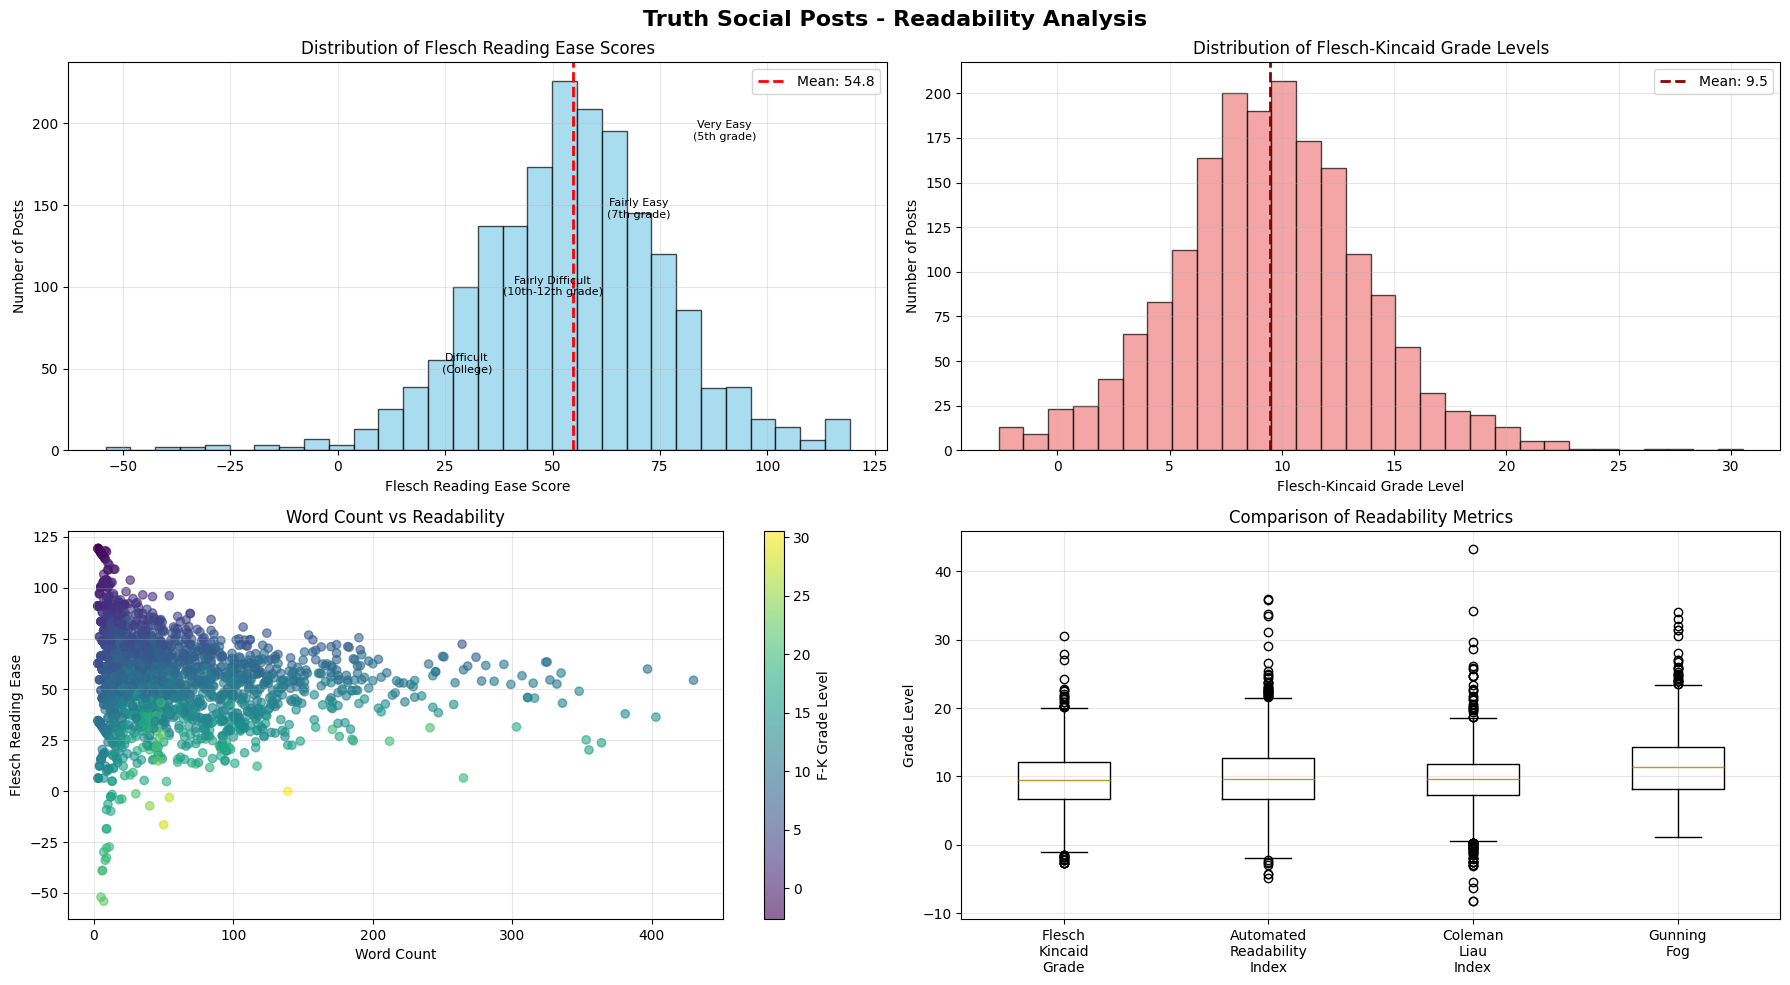

In [361]:
# Create visualizations for readability analysis
fig, axes = plt.subplots(2, 2, figsize=(18, 10))
fig.suptitle('Truth Social Posts - Readability Analysis', fontsize=16, fontweight='bold')

# 1. Flesch Reading Ease distribution
axes[0,0].hist(text_df['flesch_reading_ease'].dropna(), bins=30, alpha=0.7, color='skyblue', edgecolor='black')
axes[0,0].axvline(text_df['flesch_reading_ease'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {text_df["flesch_reading_ease"].mean():.1f}')
axes[0,0].set_xlabel('Flesch Reading Ease Score')
axes[0,0].set_ylabel('Number of Posts')
axes[0,0].set_title('Distribution of Flesch Reading Ease Scores')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# Add readability level annotations
axes[0,0].text(90, axes[0,0].get_ylim()[1]*0.8, 'Very Easy\n(5th grade)', fontsize=8, ha='center')
axes[0,0].text(70, axes[0,0].get_ylim()[1]*0.6, 'Fairly Easy\n(7th grade)', fontsize=8, ha='center')
axes[0,0].text(50, axes[0,0].get_ylim()[1]*0.4, 'Fairly Difficult\n(10th-12th grade)', fontsize=8, ha='center')
axes[0,0].text(30, axes[0,0].get_ylim()[1]*0.2, 'Difficult\n(College)', fontsize=8, ha='center')

# 2. Flesch-Kincaid Grade Level distribution  
axes[0,1].hist(text_df['flesch_kincaid_grade'].dropna(), bins=30, alpha=0.7, color='lightcoral', edgecolor='black')
axes[0,1].axvline(text_df['flesch_kincaid_grade'].mean(), color='darkred', linestyle='--', linewidth=2, label=f'Mean: {text_df["flesch_kincaid_grade"].mean():.1f}')
axes[0,1].set_xlabel('Flesch-Kincaid Grade Level')
axes[0,1].set_ylabel('Number of Posts')
axes[0,1].set_title('Distribution of Flesch-Kincaid Grade Levels')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# 3. Word count vs Readability scatter plot
scatter = axes[1,0].scatter(text_df['word_count'], text_df['flesch_reading_ease'], alpha=0.6, c=text_df['flesch_kincaid_grade'], cmap='viridis')
axes[1,0].set_xlabel('Word Count')
axes[1,0].set_ylabel('Flesch Reading Ease')
axes[1,0].set_title('Word Count vs Readability')
axes[1,0].grid(True, alpha=0.3)
plt.colorbar(scatter, ax=axes[1,0], label='F-K Grade Level')

# 4. Comparison of different readability metrics
metrics_for_comparison = ['flesch_kincaid_grade', 'automated_readability_index', 'coleman_liau_index', 'gunning_fog']
bp = axes[1,1].boxplot([text_df[metric].dropna() for metric in metrics_for_comparison], 
                       labels=[m.replace('_', '\n').title() for m in metrics_for_comparison])
axes[1,1].set_ylabel('Grade Level')
axes[1,1].set_title('Comparison of Readability Metrics')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../images/eda_figure_01.svg', format='svg', bbox_inches='tight', dpi=300)
plt.show()


In [362]:
# Show examples of posts at different readability levels
print("=== EXAMPLES OF POSTS AT DIFFERENT READABILITY LEVELS ===\n")

# Define readability categories based on Flesch Reading Ease
def categorize_readability(score):
    if score >= 80:
        return "Very Easy (5th-6th grade)"
    elif score >= 70:
        return "Fairly Easy (7th grade)"
    elif score >= 60:
        return "Standard (8th-9th grade)"
    elif score >= 50:
        return "Fairly Difficult (10th-12th grade)"
    elif score >= 30:
        return "Difficult (College level)"
    else:
        return "Very Difficult (Graduate level)"

# Add readability category to dataframe
text_df['readability_category'] = text_df['flesch_reading_ease'].apply(categorize_readability)

# Show examples from different categories
categories = text_df['readability_category'].value_counts().index[:4]  # Top 4 most common categories

for category in categories:
    category_posts = text_df[text_df['readability_category'] == category]
    if len(category_posts) > 0:
        print(f"\n{'='*60}")
        print(f"CATEGORY: {category}")
        print(f"Number of posts: {len(category_posts)}")
        print(f"Average Flesch Reading Ease: {category_posts['flesch_reading_ease'].mean():.1f}")
        print(f"Average F-K Grade Level: {category_posts['flesch_kincaid_grade'].mean():.1f}")
        print(f"{'='*60}")
        
        # Show 2 examples from this category
        examples = category_posts.nlargest(2, 'flesch_reading_ease')  # Get most readable from this category
        for i, (idx, row) in enumerate(examples.iterrows(), 1):
            print(f"\nExample {i}:")
            print(f"  Flesch Reading Ease: {row['flesch_reading_ease']:.1f}")
            print(f"  F-K Grade Level: {row['flesch_kincaid_grade']:.1f}")
            print(f"  Word Count: {row['word_count']}")
            print(f"  Text: \"{row['cleaned_text'][:200]}...\"" if len(row['cleaned_text']) > 200 else f"  Text: \"{row['cleaned_text']}\"")

print(f"\n{'='*60}")
print("READABILITY CATEGORY SUMMARY:")
print(f"{'='*60}")
category_summary = text_df['readability_category'].value_counts()
for category, count in category_summary.items():
    percentage = (count / len(text_df)) * 100
    print(f"{category}: {count} posts ({percentage:.1f}%)")


=== EXAMPLES OF POSTS AT DIFFERENT READABILITY LEVELS ===


CATEGORY: Difficult (College level)
Number of posts: 503
Average Flesch Reading Ease: 40.7
Average F-K Grade Level: 12.2

Example 1:
  Flesch Reading Ease: 50.0
  F-K Grade Level: 9.2
  Word Count: 35
  Text: "The United States is taking in RECORD NUMBERS in Tariffs, with the cost of almost all products going down, including gasoline, groceries, and just about everything else. Likewise, INFLATION is down. P..."

Example 2:
  Flesch Reading Ease: 49.9
  F-K Grade Level: 11.8
  Word Count: 44
  Text: "As First Lady, my Be Best initiative is focused on improving children's well-being, encouraging kindness and creating a safer online environment for our youth. Today, I'm proud to say that the values ..."

CATEGORY: Fairly Difficult (10th-12th grade)
Number of posts: 378
Average Flesch Reading Ease: 54.9
Average F-K Grade Level: 9.7

Example 1:
  Flesch Reading Ease: 60.0
  F-K Grade Level: 9.5
  Word Count: 131
  Text: "Speaker of

In [363]:
# Optional: Save results to CSV for further analysis
# Uncomment the line below if you want to save the results
# text_df.to_csv('truth_social_readability_analysis.csv', index=False)

# Quick summary for interpretation
print("=== KEY FINDINGS SUMMARY ===")
print(f"✓ Analyzed {len(text_df)} Truth Social posts with text content")
print(f"✓ Average reading level: {text_df['flesch_kincaid_grade'].mean():.1f} grade level")
print(f"✓ Most common readability category: {text_df['readability_category'].mode()[0]}")
print(f"✓ Average post length: {text_df['word_count'].mean():.1f} words")
print(f"✓ Flesch Reading Ease Score: {text_df['flesch_reading_ease'].mean():.1f} ({categorize_readability(text_df['flesch_reading_ease'].mean())})")

print("\n💡 Understanding the Scores:")
print("• Flesch Reading Ease: Higher scores = easier to read (0-100 scale)")
print("• Flesch-Kincaid Grade: Grade level needed to understand the text") 
print("• All other metrics also indicate approximate grade level")

print(f"\n📊 Data available in 'text_df' DataFrame with these new columns:")
readability_columns = ['flesch_reading_ease', 'flesch_kincaid_grade', 'automated_readability_index', 
                      'coleman_liau_index', 'gunning_fog', 'smog_index', 'word_count', 
                      'sentence_count', 'syllable_count', 'readability_category']
for col in readability_columns:
    print(f"   • {col}")


=== KEY FINDINGS SUMMARY ===
✓ Analyzed 1819 Truth Social posts with text content
✓ Average reading level: 9.5 grade level
✓ Most common readability category: Difficult (College level)
✓ Average post length: 61.0 words
✓ Flesch Reading Ease Score: 54.8 (Fairly Difficult (10th-12th grade))

💡 Understanding the Scores:
• Flesch Reading Ease: Higher scores = easier to read (0-100 scale)
• Flesch-Kincaid Grade: Grade level needed to understand the text
• All other metrics also indicate approximate grade level

📊 Data available in 'text_df' DataFrame with these new columns:
   • flesch_reading_ease
   • flesch_kincaid_grade
   • automated_readability_index
   • coleman_liau_index
   • gunning_fog
   • smog_index
   • word_count
   • sentence_count
   • syllable_count
   • readability_category


In [364]:
# Import sentiment analysis libraries
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from textblob import TextBlob
import nltk

# Download required NLTK data (run once)
try:
    nltk.download('punkt', quiet=True)
    nltk.download('brown', quiet=True)
    print("✓ NLTK data downloaded successfully")
except:
    print("⚠ NLTK download failed, but analysis should still work")

# Initialize VADER analyzer
analyzer = SentimentIntensityAnalyzer()

print("✓ Sentiment analysis libraries loaded and ready!")


✓ NLTK data downloaded successfully
✓ Sentiment analysis libraries loaded and ready!


In [365]:
# Prepare text for sentiment analysis (keep emojis for better sentiment detection)
def clean_text_for_sentiment(text):
    """Clean text for sentiment analysis - keeps emojis but removes noise"""
    if pd.isna(text) or text == '':
        return None
    
    # Remove RT prefix if present
    if text.startswith('RT@'):
        # Find the end of the RT attribution
        parts = text.split(' ', 1)
        if len(parts) > 1:
            text = parts[1]
        else:
            return None
    
    import re
    
    # Remove URLs but keep everything else including emojis
    text = re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', text)
    
    # Clean up extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    # Only return text that has some content
    if len(text) < 3:
        return None
    
    return text

# Calculate sentiment scores using multiple methods
def calculate_sentiment_metrics(text):
    """Calculate sentiment using both VADER and TextBlob"""
    if not text:
        return {
            'vader_compound': np.nan, 'vader_pos': np.nan, 'vader_neu': np.nan, 'vader_neg': np.nan,
            'textblob_polarity': np.nan, 'textblob_subjectivity': np.nan,
            'sentiment_category': 'Unknown'
        }
    
    try:
        # VADER sentiment (good for social media)
        vader_scores = analyzer.polarity_scores(text)
        
        # TextBlob sentiment
        blob = TextBlob(text)
        textblob_polarity = blob.sentiment.polarity
        textblob_subjectivity = blob.sentiment.subjectivity
        
        # Determine overall sentiment category based on VADER compound score
        compound = vader_scores['compound']
        if compound >= 0.05:
            sentiment_category = 'Positive'
        elif compound <= -0.05:
            sentiment_category = 'Negative'
        else:
            sentiment_category = 'Neutral'
        
        return {
            'vader_compound': vader_scores['compound'],
            'vader_pos': vader_scores['pos'],
            'vader_neu': vader_scores['neu'],
            'vader_neg': vader_scores['neg'],
            'textblob_polarity': textblob_polarity,
            'textblob_subjectivity': textblob_subjectivity,
            'sentiment_category': sentiment_category
        }
    except Exception as e:
        print(f"Error analyzing sentiment: {e}")
        return {
            'vader_compound': np.nan, 'vader_pos': np.nan, 'vader_neu': np.nan, 'vader_neg': np.nan,
            'textblob_polarity': np.nan, 'textblob_subjectivity': np.nan,
            'sentiment_category': 'Error'
        }

# Apply sentiment cleaning to all posts (use original content_text for sentiment)
df['sentiment_text'] = df['content_text'].apply(clean_text_for_sentiment)

# Filter to posts with sentiment-analyzable text
sentiment_df = df[df['sentiment_text'].notna()].copy()

print(f"Posts available for sentiment analysis: {len(sentiment_df)}")
print(f"Percentage of total posts: {len(sentiment_df)/len(df)*100:.1f}%")


Posts available for sentiment analysis: 1844
Percentage of total posts: 53.0%


In [366]:
# Calculate sentiment metrics for all posts
print("Calculating sentiment metrics...")
sentiment_data = []
for idx, text in sentiment_df['sentiment_text'].items():
    metrics = calculate_sentiment_metrics(text)
    metrics['original_index'] = idx
    sentiment_data.append(metrics)

# Create sentiment DataFrame
sentiment_results_df = pd.DataFrame(sentiment_data)
sentiment_results_df = sentiment_results_df.set_index('original_index')

# Merge with original data
sentiment_df = sentiment_df.join(sentiment_results_df)

print("Sentiment analysis complete!")
print(f"Successfully analyzed {len(sentiment_df)} posts")

# Merge with readability analysis if it exists (for posts that have both)
if 'text_df' in locals():
    # Find posts that have both readability and sentiment analysis
    combined_df = sentiment_df.join(text_df[['flesch_reading_ease', 'flesch_kincaid_grade', 
                                             'word_count', 'readability_category']], how='inner')
    print(f"Posts with both sentiment and readability analysis: {len(combined_df)}")
else:
    combined_df = sentiment_df.copy()
    
print("Datasets ready for analysis!")


Calculating sentiment metrics...
Sentiment analysis complete!
Successfully analyzed 1844 posts
Posts with both sentiment and readability analysis: 1819
Datasets ready for analysis!


In [367]:
# Sentiment Analysis Summary Statistics
print("=== SENTIMENT ANALYSIS SUMMARY ===\n")

print("OVERALL SENTIMENT DISTRIBUTION:")
print("="*40)
sentiment_counts = sentiment_df['sentiment_category'].value_counts()
total_posts = len(sentiment_df)

for sentiment, count in sentiment_counts.items():
    percentage = (count / total_posts) * 100
    print(f"{sentiment}: {count} posts ({percentage:.1f}%)")

print(f"\n{'='*40}")
print("VADER SENTIMENT SCORES (Range: -1 to +1):")
print(f"{'='*40}")

vader_compound_mean = sentiment_df['vader_compound'].mean()
print(f"Average Compound Score: {vader_compound_mean:.3f}")

if vader_compound_mean >= 0.05:
    overall_tone = "Positive"
elif vader_compound_mean <= -0.05:
    overall_tone = "Negative" 
else:
    overall_tone = "Neutral"

print(f"Overall Tone: {overall_tone}")

print(f"\nVADER Score Breakdown:")
print(f"  Positive component: {sentiment_df['vader_pos'].mean():.3f}")
print(f"  Neutral component: {sentiment_df['vader_neu'].mean():.3f}")
print(f"  Negative component: {sentiment_df['vader_neg'].mean():.3f}")

print(f"\n{'='*40}")
print("TEXTBLOB SENTIMENT SCORES:")
print(f"{'='*40}")

tb_polarity_mean = sentiment_df['textblob_polarity'].mean()
tb_subjectivity_mean = sentiment_df['textblob_subjectivity'].mean()

print(f"Average Polarity: {tb_polarity_mean:.3f} (Range: -1=negative to +1=positive)")
print(f"Average Subjectivity: {tb_subjectivity_mean:.3f} (Range: 0=objective to 1=subjective)")

if tb_subjectivity_mean > 0.5:
    subjectivity_level = "Highly Subjective (personal opinions/emotions)"
elif tb_subjectivity_mean > 0.3:
    subjectivity_level = "Moderately Subjective"
else:
    subjectivity_level = "Relatively Objective (factual)"

print(f"Subjectivity Level: {subjectivity_level}")

print(f"\n{'='*40}")
print("SENTIMENT SCORE DISTRIBUTIONS:")
print(f"{'='*40}")

sentiment_metrics = ['vader_compound', 'vader_pos', 'vader_neg', 'textblob_polarity', 'textblob_subjectivity']
for metric in sentiment_metrics:
    print(f"\n{metric.replace('_', ' ').title()}:")
    print(f"  Mean: {sentiment_df[metric].mean():.3f}")
    print(f"  Median: {sentiment_df[metric].median():.3f}")
    print(f"  Std Dev: {sentiment_df[metric].std():.3f}")
    print(f"  Min: {sentiment_df[metric].min():.3f}")
    print(f"  Max: {sentiment_df[metric].max():.3f}")


=== SENTIMENT ANALYSIS SUMMARY ===

OVERALL SENTIMENT DISTRIBUTION:
Positive: 1185 posts (64.3%)
Negative: 436 posts (23.6%)
Neutral: 223 posts (12.1%)

VADER SENTIMENT SCORES (Range: -1 to +1):
Average Compound Score: 0.339
Overall Tone: Positive

VADER Score Breakdown:
  Positive component: 0.184
  Neutral component: 0.742
  Negative component: 0.073

TEXTBLOB SENTIMENT SCORES:
Average Polarity: 0.176 (Range: -1=negative to +1=positive)
Average Subjectivity: 0.459 (Range: 0=objective to 1=subjective)
Subjectivity Level: Moderately Subjective

SENTIMENT SCORE DISTRIBUTIONS:

Vader Compound:
  Mean: 0.339
  Median: 0.622
  Std Dev: 0.655
  Min: -0.996
  Max: 0.997

Vader Pos:
  Mean: 0.184
  Median: 0.164
  Std Dev: 0.154
  Min: 0.000
  Max: 1.000

Vader Neg:
  Mean: 0.073
  Median: 0.034
  Std Dev: 0.101
  Min: 0.000
  Max: 1.000

Textblob Polarity:
  Mean: 0.176
  Median: 0.150
  Std Dev: 0.300
  Min: -1.000
  Max: 1.000

Textblob Subjectivity:
  Mean: 0.459
  Median: 0.497
  Std Dev

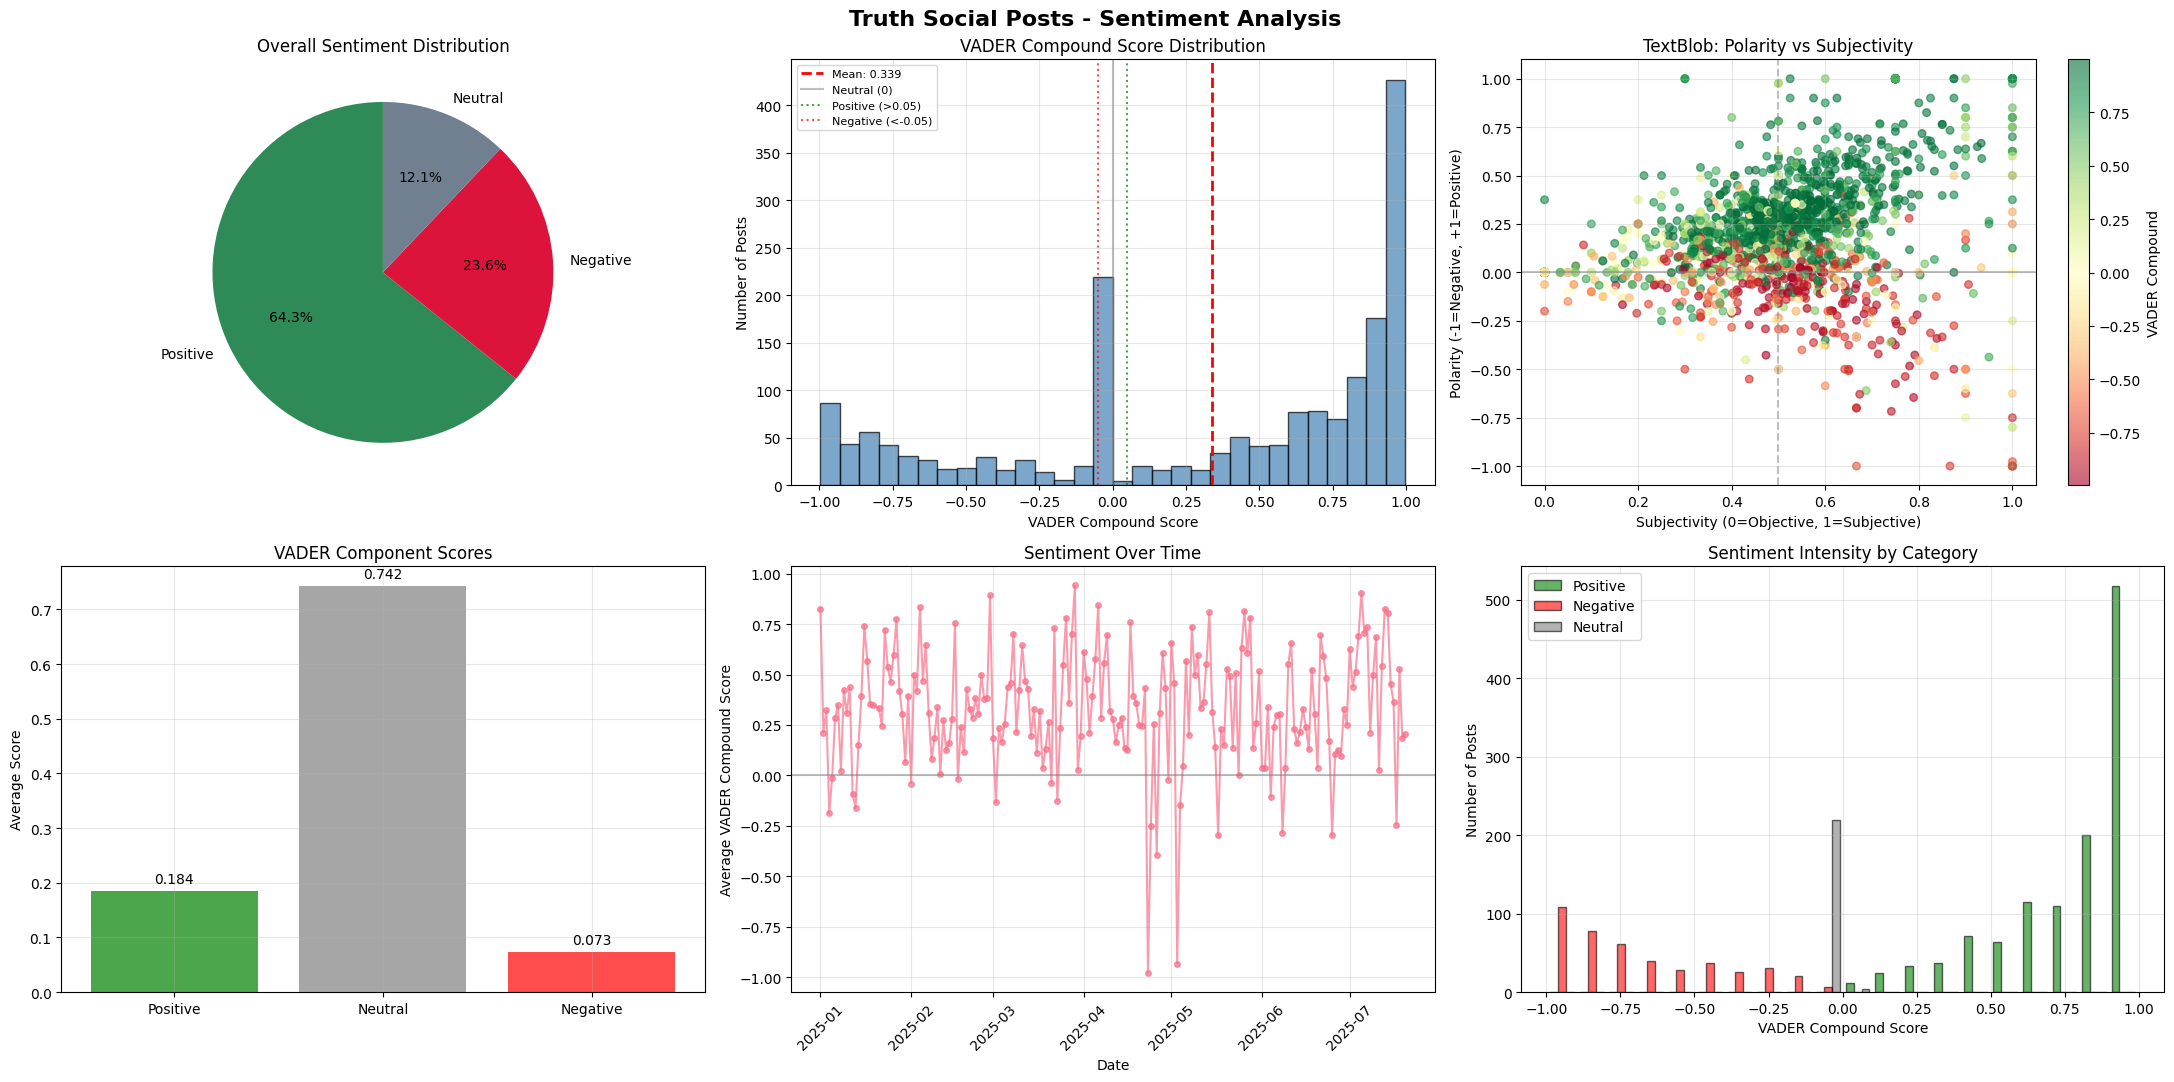

In [368]:
# Create sentiment analysis visualizations
fig, axes = plt.subplots(2, 3, figsize=(22, 11))
fig.suptitle('Truth Social Posts - Sentiment Analysis', fontsize=16, fontweight='bold')

# 1. Sentiment Category Distribution (Pie Chart)
sentiment_counts = sentiment_df['sentiment_category'].value_counts()
colors = ['#2E8B57', '#DC143C', '#708090']  # Green, Red, Gray for Positive, Negative, Neutral
axes[0,0].pie(sentiment_counts.values, labels=sentiment_counts.index, autopct='%1.1f%%', 
              colors=colors[:len(sentiment_counts)], startangle=90)
axes[0,0].set_title('Overall Sentiment Distribution')

# 2. VADER Compound Score Distribution
axes[0,1].hist(sentiment_df['vader_compound'].dropna(), bins=30, alpha=0.7, color='steelblue', edgecolor='black')
axes[0,1].axvline(sentiment_df['vader_compound'].mean(), color='red', linestyle='--', linewidth=2, 
                  label=f'Mean: {sentiment_df["vader_compound"].mean():.3f}')
axes[0,1].axvline(0, color='gray', linestyle='-', alpha=0.5, label='Neutral (0)')
axes[0,1].axvline(0.05, color='green', linestyle=':', alpha=0.7, label='Positive (>0.05)')
axes[0,1].axvline(-0.05, color='red', linestyle=':', alpha=0.7, label='Negative (<-0.05)')
axes[0,1].set_xlabel('VADER Compound Score')
axes[0,1].set_ylabel('Number of Posts')
axes[0,1].set_title('VADER Compound Score Distribution')
axes[0,1].legend(fontsize=8)
axes[0,1].grid(True, alpha=0.3)

# 3. TextBlob Polarity vs Subjectivity Scatter
scatter = axes[0,2].scatter(sentiment_df['textblob_subjectivity'], sentiment_df['textblob_polarity'], 
                           alpha=0.6, c=sentiment_df['vader_compound'], cmap='RdYlGn', s=30)
axes[0,2].set_xlabel('Subjectivity (0=Objective, 1=Subjective)')
axes[0,2].set_ylabel('Polarity (-1=Negative, +1=Positive)')
axes[0,2].set_title('TextBlob: Polarity vs Subjectivity')
axes[0,2].axhline(0, color='gray', linestyle='-', alpha=0.5)
axes[0,2].axvline(0.5, color='gray', linestyle='--', alpha=0.5)
axes[0,2].grid(True, alpha=0.3)
plt.colorbar(scatter, ax=axes[0,2], label='VADER Compound')

# 4. VADER Components Comparison
vader_components = ['vader_pos', 'vader_neu', 'vader_neg']
component_means = [sentiment_df[comp].mean() for comp in vader_components]
component_labels = ['Positive', 'Neutral', 'Negative']
bars = axes[1,0].bar(component_labels, component_means, color=['green', 'gray', 'red'], alpha=0.7)
axes[1,0].set_ylabel('Average Score')
axes[1,0].set_title('VADER Component Scores')
axes[1,0].grid(True, alpha=0.3)
# Add value labels on bars
for bar, value in zip(bars, component_means):
    axes[1,0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                   f'{value:.3f}', ha='center', va='bottom')

# 5. Sentiment by Time (if date information is available)
if 'date_parsed' in sentiment_df.columns:
    # Convert date and group by day
    sentiment_df['date'] = pd.to_datetime(sentiment_df['date_parsed'])
    daily_sentiment = sentiment_df.groupby(sentiment_df['date'].dt.date)['vader_compound'].mean()
    
    axes[1,1].plot(daily_sentiment.index, daily_sentiment.values, marker='o', alpha=0.7, markersize=4)
    axes[1,1].axhline(0, color='gray', linestyle='-', alpha=0.5)
    axes[1,1].set_xlabel('Date')
    axes[1,1].set_ylabel('Average VADER Compound Score')
    axes[1,1].set_title('Sentiment Over Time')
    axes[1,1].tick_params(axis='x', rotation=45)
    axes[1,1].grid(True, alpha=0.3)
else:
    axes[1,1].text(0.5, 0.5, 'No date information\navailable', ha='center', va='center', 
                   transform=axes[1,1].transAxes, fontsize=12)
    axes[1,1].set_title('Sentiment Over Time')

# 6. Sentiment Intensity Distribution
axes[1,2].hist([sentiment_df[sentiment_df['sentiment_category'] == 'Positive']['vader_compound'].dropna(),
                sentiment_df[sentiment_df['sentiment_category'] == 'Negative']['vader_compound'].dropna(),
                sentiment_df[sentiment_df['sentiment_category'] == 'Neutral']['vader_compound'].dropna()],
               bins=20, alpha=0.6, color=['green', 'red', 'gray'], 
               label=['Positive', 'Negative', 'Neutral'], edgecolor='black')
axes[1,2].set_xlabel('VADER Compound Score')
axes[1,2].set_ylabel('Number of Posts')
axes[1,2].set_title('Sentiment Intensity by Category')
axes[1,2].legend()
axes[1,2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../images/eda_figure_02.svg', format='svg', bbox_inches='tight', dpi=300)
plt.show()


In [369]:
# Show examples of posts at different sentiment levels
print("=== EXAMPLES OF POSTS AT DIFFERENT SENTIMENT LEVELS ===\n")

def get_sentiment_interpretation(vader_score):
    """Interpret VADER compound score"""
    if vader_score >= 0.5:
        return "Very Positive"
    elif vader_score >= 0.05:
        return "Positive"
    elif vader_score <= -0.5:
        return "Very Negative"
    elif vader_score <= -0.05:
        return "Negative"
    else:
        return "Neutral"

# Show examples from each sentiment category
for category in ['Positive', 'Negative', 'Neutral']:
    category_posts = sentiment_df[sentiment_df['sentiment_category'] == category]
    if len(category_posts) > 0:
        print(f"\n{'='*60}")
        print(f"CATEGORY: {category.upper()} POSTS")
        print(f"Number of posts: {len(category_posts)}")
        print(f"Average VADER Compound: {category_posts['vader_compound'].mean():.3f}")
        print(f"Average TextBlob Polarity: {category_posts['textblob_polarity'].mean():.3f}")
        print(f"{'='*60}")
        
        # Get most extreme examples from this category
        if category == 'Positive':
            examples = category_posts.nlargest(3, 'vader_compound')
        elif category == 'Negative':
            examples = category_posts.nsmallest(3, 'vader_compound')
        else:  # Neutral
            # For neutral, get posts closest to 0
            examples = category_posts.loc[category_posts['vader_compound'].abs().nsmallest(3).index]
        
        for i, (idx, row) in enumerate(examples.iterrows(), 1):
            print(f"\nExample {i}:")
            print(f"  VADER Compound: {row['vader_compound']:.3f} ({get_sentiment_interpretation(row['vader_compound'])})")
            print(f"  VADER Components - Pos: {row['vader_pos']:.3f}, Neu: {row['vader_neu']:.3f}, Neg: {row['vader_neg']:.3f}")
            print(f"  TextBlob Polarity: {row['textblob_polarity']:.3f}")
            print(f"  TextBlob Subjectivity: {row['textblob_subjectivity']:.3f}")
            # Show original text (with emojis)
            display_text = row['sentiment_text'][:300] + "..." if len(row['sentiment_text']) > 300 else row['sentiment_text']
            print(f"  Text: \"{display_text}\"")

print(f"\n{'='*60}")
print("MOST EXTREME SENTIMENT EXAMPLES:")
print(f"{'='*60}")

# Most positive post
most_positive = sentiment_df.loc[sentiment_df['vader_compound'].idxmax()]
print(f"\n🟢 MOST POSITIVE POST (VADER: {most_positive['vader_compound']:.3f}):")
display_text = most_positive['sentiment_text'][:400] + "..." if len(most_positive['sentiment_text']) > 400 else most_positive['sentiment_text']
print(f'"{display_text}"')

# Most negative post  
most_negative = sentiment_df.loc[sentiment_df['vader_compound'].idxmin()]
print(f"\n🔴 MOST NEGATIVE POST (VADER: {most_negative['vader_compound']:.3f}):")
display_text = most_negative['sentiment_text'][:400] + "..." if len(most_negative['sentiment_text']) > 400 else most_negative['sentiment_text']
print(f'"{display_text}"')

# Most neutral post
most_neutral_idx = sentiment_df['vader_compound'].abs().idxmin()
most_neutral = sentiment_df.loc[most_neutral_idx]
print(f"\n⚪ MOST NEUTRAL POST (VADER: {most_neutral['vader_compound']:.3f}):")
display_text = most_neutral['sentiment_text'][:400] + "..." if len(most_neutral['sentiment_text']) > 400 else most_neutral['sentiment_text']
print(f'"{display_text}"')


=== EXAMPLES OF POSTS AT DIFFERENT SENTIMENT LEVELS ===


CATEGORY: POSITIVE POSTS
Number of posts: 1185
Average VADER Compound: 0.775
Average TextBlob Polarity: 0.289

Example 1:
  VADER Compound: 0.997 (Very Positive)
  VADER Components - Pos: 0.268, Neu: 0.732, Neg: 0.000
  TextBlob Polarity: 0.326
  TextBlob Subjectivity: 0.447
  Text: "Ed Martin is going through the approval process to be U.S. Attorney in the District of Columbia. According to many but, in particular, Robert F. Kennedy, Jr., his approval is IMPERATIVE in terms of doing all that has to be done to SAVE LIVES and to, MAKE AMERICA HEALTHY AGAIN. This is a passion for ..."

Example 2:
  VADER Compound: 0.997 (Very Positive)
  VADER Components - Pos: 0.309, Neu: 0.684, Neg: 0.007
  TextBlob Polarity: 0.153
  TextBlob Subjectivity: 0.527
  Text: "It is my great honor to appoint Sean Curran as the next Director of the United States Secret Service. Sean is a Great Patriot, who has protected my family over the past few year

=== SENTIMENT vs READABILITY ANALYSIS ===

CORRELATION ANALYSIS:
Sentiment vs Reading Ease: -0.103 (Weak Negative)
Sentiment vs Grade Level: 0.111 (Weak Positive)
Sentiment vs Word Count: 0.043 (Weak Positive)
Subjectivity vs Reading Ease: 0.069 (Weak Positive)
Subjectivity vs Grade Level: -0.016 (Weak Negative)

READABILITY BY SENTIMENT CATEGORY:

Positive Posts (1174 posts):
  Average Reading Ease: 53.4
  Average Grade Level: 9.9
  Average Word Count: 64.9

Negative Posts (436 posts):
  Average Reading Ease: 57.6
  Average Grade Level: 9.3
  Average Word Count: 73.8

Neutral Posts (209 posts):
  Average Reading Ease: 57.1
  Average Grade Level: 7.7
  Average Word Count: 12.1


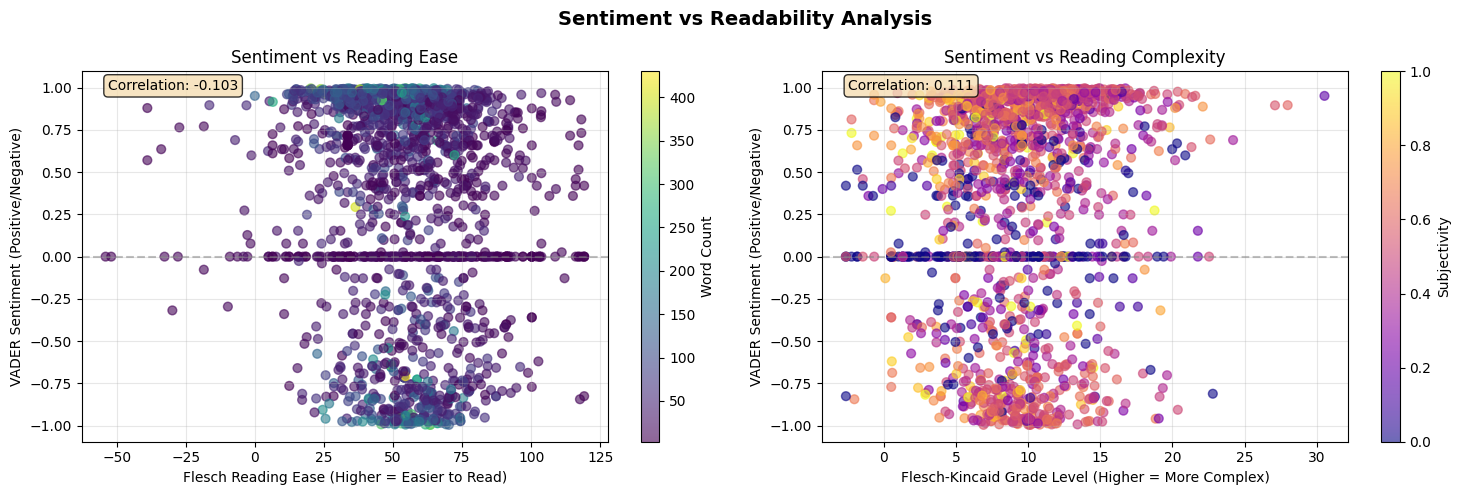

In [370]:
# Analyze relationships between sentiment and readability (if both are available)
if 'combined_df' in locals() and len(combined_df) > 0:
    print("=== SENTIMENT vs READABILITY ANALYSIS ===\n")
    
    # Calculate correlations
    correlations = {
        'Sentiment vs Reading Ease': combined_df['vader_compound'].corr(combined_df['flesch_reading_ease']),
        'Sentiment vs Grade Level': combined_df['vader_compound'].corr(combined_df['flesch_kincaid_grade']),
        'Sentiment vs Word Count': combined_df['vader_compound'].corr(combined_df['word_count']),
        'Subjectivity vs Reading Ease': combined_df['textblob_subjectivity'].corr(combined_df['flesch_reading_ease']),
        'Subjectivity vs Grade Level': combined_df['textblob_subjectivity'].corr(combined_df['flesch_kincaid_grade'])
    }
    
    print("CORRELATION ANALYSIS:")
    print("="*40)
    for relationship, correlation in correlations.items():
        strength = "Strong" if abs(correlation) > 0.5 else "Moderate" if abs(correlation) > 0.3 else "Weak"
        direction = "Positive" if correlation > 0 else "Negative"
        print(f"{relationship}: {correlation:.3f} ({strength} {direction})")
    
    # Group analysis by sentiment category
    print(f"\n{'='*40}")
    print("READABILITY BY SENTIMENT CATEGORY:")
    print(f"{'='*40}")
    
    for category in ['Positive', 'Negative', 'Neutral']:
        cat_data = combined_df[combined_df['sentiment_category'] == category]
        if len(cat_data) > 0:
            print(f"\n{category} Posts ({len(cat_data)} posts):")
            print(f"  Average Reading Ease: {cat_data['flesch_reading_ease'].mean():.1f}")
            print(f"  Average Grade Level: {cat_data['flesch_kincaid_grade'].mean():.1f}")
            print(f"  Average Word Count: {cat_data['word_count'].mean():.1f}")
            
    # Create correlation visualization
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    fig.suptitle('Sentiment vs Readability Analysis', fontsize=14, fontweight='bold')
    
    # Sentiment vs Reading Ease
    scatter1 = axes[0].scatter(combined_df['flesch_reading_ease'], combined_df['vader_compound'], 
                               alpha=0.6, c=combined_df['word_count'], cmap='viridis', s=40)
    axes[0].set_xlabel('Flesch Reading Ease (Higher = Easier to Read)')
    axes[0].set_ylabel('VADER Sentiment (Positive/Negative)')
    axes[0].set_title('Sentiment vs Reading Ease')
    axes[0].axhline(0, color='gray', linestyle='--', alpha=0.5)
    axes[0].grid(True, alpha=0.3)
    plt.colorbar(scatter1, ax=axes[0], label='Word Count')
    
    # Add correlation text
    r = combined_df['vader_compound'].corr(combined_df['flesch_reading_ease'])
    axes[0].text(0.05, 0.95, f'Correlation: {r:.3f}', transform=axes[0].transAxes, 
                bbox=dict(boxstyle="round", facecolor='wheat', alpha=0.8))
    
    # Sentiment vs Grade Level
    scatter2 = axes[1].scatter(combined_df['flesch_kincaid_grade'], combined_df['vader_compound'], 
                               alpha=0.6, c=combined_df['textblob_subjectivity'], cmap='plasma', s=40)
    axes[1].set_xlabel('Flesch-Kincaid Grade Level (Higher = More Complex)')
    axes[1].set_ylabel('VADER Sentiment (Positive/Negative)')
    axes[1].set_title('Sentiment vs Reading Complexity')
    axes[1].axhline(0, color='gray', linestyle='--', alpha=0.5)
    axes[1].grid(True, alpha=0.3)
    plt.colorbar(scatter2, ax=axes[1], label='Subjectivity')
    
    # Add correlation text
    r2 = combined_df['vader_compound'].corr(combined_df['flesch_kincaid_grade'])
    axes[1].text(0.05, 0.95, f'Correlation: {r2:.3f}', transform=axes[1].transAxes,
                bbox=dict(boxstyle="round", facecolor='wheat', alpha=0.8))
    
    plt.tight_layout()
    plt.savefig('../images/eda_figure_03.svg', format='svg', bbox_inches='tight', dpi=300)
    plt.show()
    
else:
    print("=== SENTIMENT vs READABILITY ANALYSIS ===")
    print("Note: Run readability analysis first to see correlations between sentiment and readability metrics.")


In [371]:
# Final Summary and Data Export Options
print("=== COMPREHENSIVE ANALYSIS SUMMARY ===\n")

print("📊 DATASET OVERVIEW:")
print(f"✓ Total posts analyzed for sentiment: {len(sentiment_df)}")
if 'text_df' in locals():
    print(f"✓ Total posts analyzed for readability: {len(text_df)}")
if 'combined_df' in locals() and len(combined_df) > 0:
    print(f"✓ Posts with both sentiment and readability analysis: {len(combined_df)}")

print(f"\n🎭 SENTIMENT KEY FINDINGS:")
sentiment_mode = sentiment_df['sentiment_category'].mode()[0]
print(f"✓ Overall sentiment trend: {sentiment_df['vader_compound'].mean():.3f} (0=neutral, -1 to +1)")
print(f"✓ Most common sentiment: {sentiment_mode}")
print(f"✓ Average subjectivity: {sentiment_df['textblob_subjectivity'].mean():.3f} (0=objective, 1=subjective)")

if 'text_df' in locals():
    print(f"\n📚 READABILITY KEY FINDINGS:")
    print(f"✓ Average reading level: {text_df['flesch_kincaid_grade'].mean():.1f} grade")
    print(f"✓ Average reading ease: {text_df['flesch_reading_ease'].mean():.1f} (0-100, higher=easier)")
    readability_mode = text_df['readability_category'].mode()[0]
    print(f"✓ Most common readability level: {readability_mode}")

print(f"\n💡 UNDERSTANDING THE METRICS:")
print("SENTIMENT SCORES:")
print("• VADER Compound: Overall sentiment (-1=very negative, +1=very positive)")
print("• VADER Components: Breakdown of positive, neutral, negative aspects")
print("• TextBlob Polarity: Similar to VADER but different algorithm (-1 to +1)")
print("• TextBlob Subjectivity: How opinion-based vs factual (0=objective, 1=subjective)")

print("\nREADABILITY SCORES:")
print("• Flesch Reading Ease: How easy to read (0-100, higher=easier)")
print("• Flesch-Kincaid Grade: US grade level needed to understand")
print("• Other metrics: Various algorithms measuring complexity")

# Data export options
print(f"\n💾 DATA EXPORT OPTIONS:")
print("Uncomment any of the following lines to save your analysis results:")
print("# sentiment_df.to_csv('truth_social_sentiment_analysis.csv', index=False)")
if 'text_df' in locals():
    print("# text_df.to_csv('truth_social_readability_analysis.csv', index=False)")
if 'combined_df' in locals() and len(combined_df) > 0:
    print("# combined_df.to_csv('truth_social_complete_analysis.csv', index=False)")

print(f"\n📋 AVAILABLE DATAFRAMES:")
print("• sentiment_df: All posts with sentiment analysis")
if 'text_df' in locals():
    print("• text_df: All posts with readability analysis") 
if 'combined_df' in locals() and len(combined_df) > 0:
    print("• combined_df: Posts with both sentiment AND readability analysis")

print(f"\n🔍 SUGGESTED FURTHER ANALYSIS:")
print("• Time-based trends (sentiment/readability over time)")
print("• Topic modeling combined with sentiment")
print("• Compare sentiment of different content types (retweets vs original)")
print("• Analyze correlation with engagement metrics (if available)")
print("• Word frequency analysis by sentiment category")

print(f"\n✅ ANALYSIS COMPLETE!")
print("All sentiment analysis tools and data are ready for further exploration.")


=== COMPREHENSIVE ANALYSIS SUMMARY ===

📊 DATASET OVERVIEW:
✓ Total posts analyzed for sentiment: 1844
✓ Total posts analyzed for readability: 1819
✓ Posts with both sentiment and readability analysis: 1819

🎭 SENTIMENT KEY FINDINGS:
✓ Overall sentiment trend: 0.339 (0=neutral, -1 to +1)
✓ Most common sentiment: Positive
✓ Average subjectivity: 0.459 (0=objective, 1=subjective)

📚 READABILITY KEY FINDINGS:
✓ Average reading level: 9.5 grade
✓ Average reading ease: 54.8 (0-100, higher=easier)
✓ Most common readability level: Difficult (College level)

💡 UNDERSTANDING THE METRICS:
SENTIMENT SCORES:
• VADER Compound: Overall sentiment (-1=very negative, +1=very positive)
• VADER Components: Breakdown of positive, neutral, negative aspects
• TextBlob Polarity: Similar to VADER but different algorithm (-1 to +1)
• TextBlob Subjectivity: How opinion-based vs factual (0=objective, 1=subjective)

READABILITY SCORES:
• Flesch Reading Ease: How easy to read (0-100, higher=easier)
• Flesch-Kincai

In [372]:
# Import libraries for word analysis
from wordcloud import WordCloud
from collections import Counter, defaultdict
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import string
import warnings
warnings.filterwarnings('ignore')

print("✓ Word analysis libraries loaded!")


✓ Word analysis libraries loaded!


In [373]:
# Prepare text for word analysis (different cleaning approach for linguistic patterns)
def clean_text_for_word_analysis(text):
    """Clean text while preserving important linguistic patterns"""
    if pd.isna(text) or text == '':
        return None
    
    # Remove RT prefix if present
    if text.startswith('RT@'):
        parts = text.split(' ', 1)
        if len(parts) > 1:
            text = parts[1]
        else:
            return None
    
    import re
    
    # Remove URLs
    text = re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', text)
    
    # Remove @ mentions but keep the text structure
    text = re.sub(r'@\w+', '', text)
    
    # Keep hashtag text without # (these are often important keywords)
    text = re.sub(r'#(\w+)', r'\1', text)
    
    # Remove emojis for word analysis
    emoji_pattern = re.compile(
        "["
        "\U0001F600-\U0001F64F"  # emoticons
        "\U0001F300-\U0001F5FF"  # symbols & pictographs
        "\U0001F680-\U0001F6FF"  # transport & map symbols
        "\U0001F1E0-\U0001F1FF"  # flags (iOS)
        "\U0001F900-\U0001F9FF"  # supplemental symbols
        "\U00002600-\U000026FF"  # miscellaneous symbols
        "\U00002700-\U000027BF"  # dingbats
        "\U0000FE00-\U0000FE0F"  # variation selectors
        "\U0001F170-\U0001F251"  # enclosed characters
        "\U00001F00-\U00001F9F"  # various symbols
        "\U00002000-\U0000206F"  # general punctuation
        "\U0000E000-\U0000F8FF"  # private use area
        "]+"
    )
    text = emoji_pattern.sub('', text)
    
    # Clean up extra whitespace but preserve punctuation for linguistic analysis
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text if len(text) > 3 else None

# Apply word analysis cleaning
df['word_analysis_text'] = df['content_text'].apply(clean_text_for_word_analysis)

# Get posts suitable for word analysis
word_analysis_df = df[df['word_analysis_text'].notna()].copy()

print(f"Posts available for word analysis: {len(word_analysis_df)}")

# Combine all text for overall analysis
all_text = ' '.join(word_analysis_df['word_analysis_text'].dropna())
print(f"Total characters for analysis: {len(all_text):,}")
print(f"Sample text: {all_text[:200]}...")


Posts available for word analysis: 1842
Total characters for analysis: 659,299
Sample text: Adam Shifty Schiff is in BIG TROUBLE! He falsified Loan Documents. He once said my son would go to prison on a SCAM that Schiff, along with other Crooked Dems, illegally manufactured in order to stage...


In [374]:
# Basic word frequency analysis
print("=== WORD FREQUENCY ANALYSIS ===\n")

# Split text into words and count frequencies
import re
words = re.findall(r'\b[a-zA-Z]+\b', all_text.lower())
word_freq = Counter(words)

# Define common stop words to filter out (but keep some that might be distinctive)
basic_stopwords = {'the', 'a', 'an', 'and', 'or', 'but', 'in', 'on', 'at', 'to', 'for', 'of', 'with', 'by', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'do', 'does', 'did', 'will', 'would', 'could', 'should', 'may', 'might', 'must', 'can', 'this', 'that', 'these', 'those', 'i', 'you', 'he', 'she', 'it', 'we', 'they', 'me', 'him', 'her', 'us', 'them', 'my', 'your', 'his', 'her', 'its', 'our', 'their'}

# Get words that are NOT basic stopwords
filtered_words = {word: count for word, count in word_freq.items() if word not in basic_stopwords and len(word) > 2}

print("OVERALL WORD STATISTICS:")
print(f"• Total words: {len(words):,}")
print(f"• Unique words: {len(word_freq):,}")
print(f"• Unique content words (filtered): {len(filtered_words):,}")
print(f"• Average word length: {np.mean([len(word) for word in words]):.1f} characters")

print(f"\nTOP 30 MOST FREQUENT CONTENT WORDS:")
print("="*50)
for i, (word, count) in enumerate(Counter(filtered_words).most_common(30), 1):
    percentage = (count / len(words)) * 100
    print(f"{i:2d}. {word:<15} | {count:4d} times ({percentage:.2f}%)")

# Analyze word length distribution
word_lengths = [len(word) for word in words]
print(f"\nWORD LENGTH ANALYSIS:")
print(f"• Average length: {np.mean(word_lengths):.1f} characters")
print(f"• Median length: {np.median(word_lengths):.1f} characters")
print(f"• Shortest words: {min(word_lengths)} characters")
print(f"• Longest words: {max(word_lengths)} characters")

# Find longest words used
longest_words = [word for word in words if len(word) >= 10]
if longest_words:
    longest_word_freq = Counter(longest_words)
    print(f"\nLONGEST WORDS (10+ characters):")
    for word, count in longest_word_freq.most_common(10):
        print(f"• {word} ({len(word)} chars): {count} times")


=== WORD FREQUENCY ANALYSIS ===

OVERALL WORD STATISTICS:
• Total words: 111,369
• Unique words: 8,215
• Unique content words (filtered): 8,070
• Average word length: 4.7 characters

TOP 30 MOST FREQUENT CONTENT WORDS:
 1. great           |  698 times (0.63%)
 2. america         |  535 times (0.48%)
 3. all             |  504 times (0.45%)
 4. not             |  437 times (0.39%)
 5. president       |  437 times (0.39%)
 6. united          |  409 times (0.37%)
 7. states          |  409 times (0.37%)
 8. country         |  400 times (0.36%)
 9. very            |  399 times (0.36%)
10. from            |  398 times (0.36%)
11. trump           |  385 times (0.35%)
12. people          |  365 times (0.33%)
13. who             |  357 times (0.32%)
14. american        |  307 times (0.28%)
15. make            |  289 times (0.26%)
16. now             |  278 times (0.25%)
17. just            |  265 times (0.24%)
18. one             |  261 times (0.23%)
19. again           |  251 times (0.23%)
20

Generating word clouds...


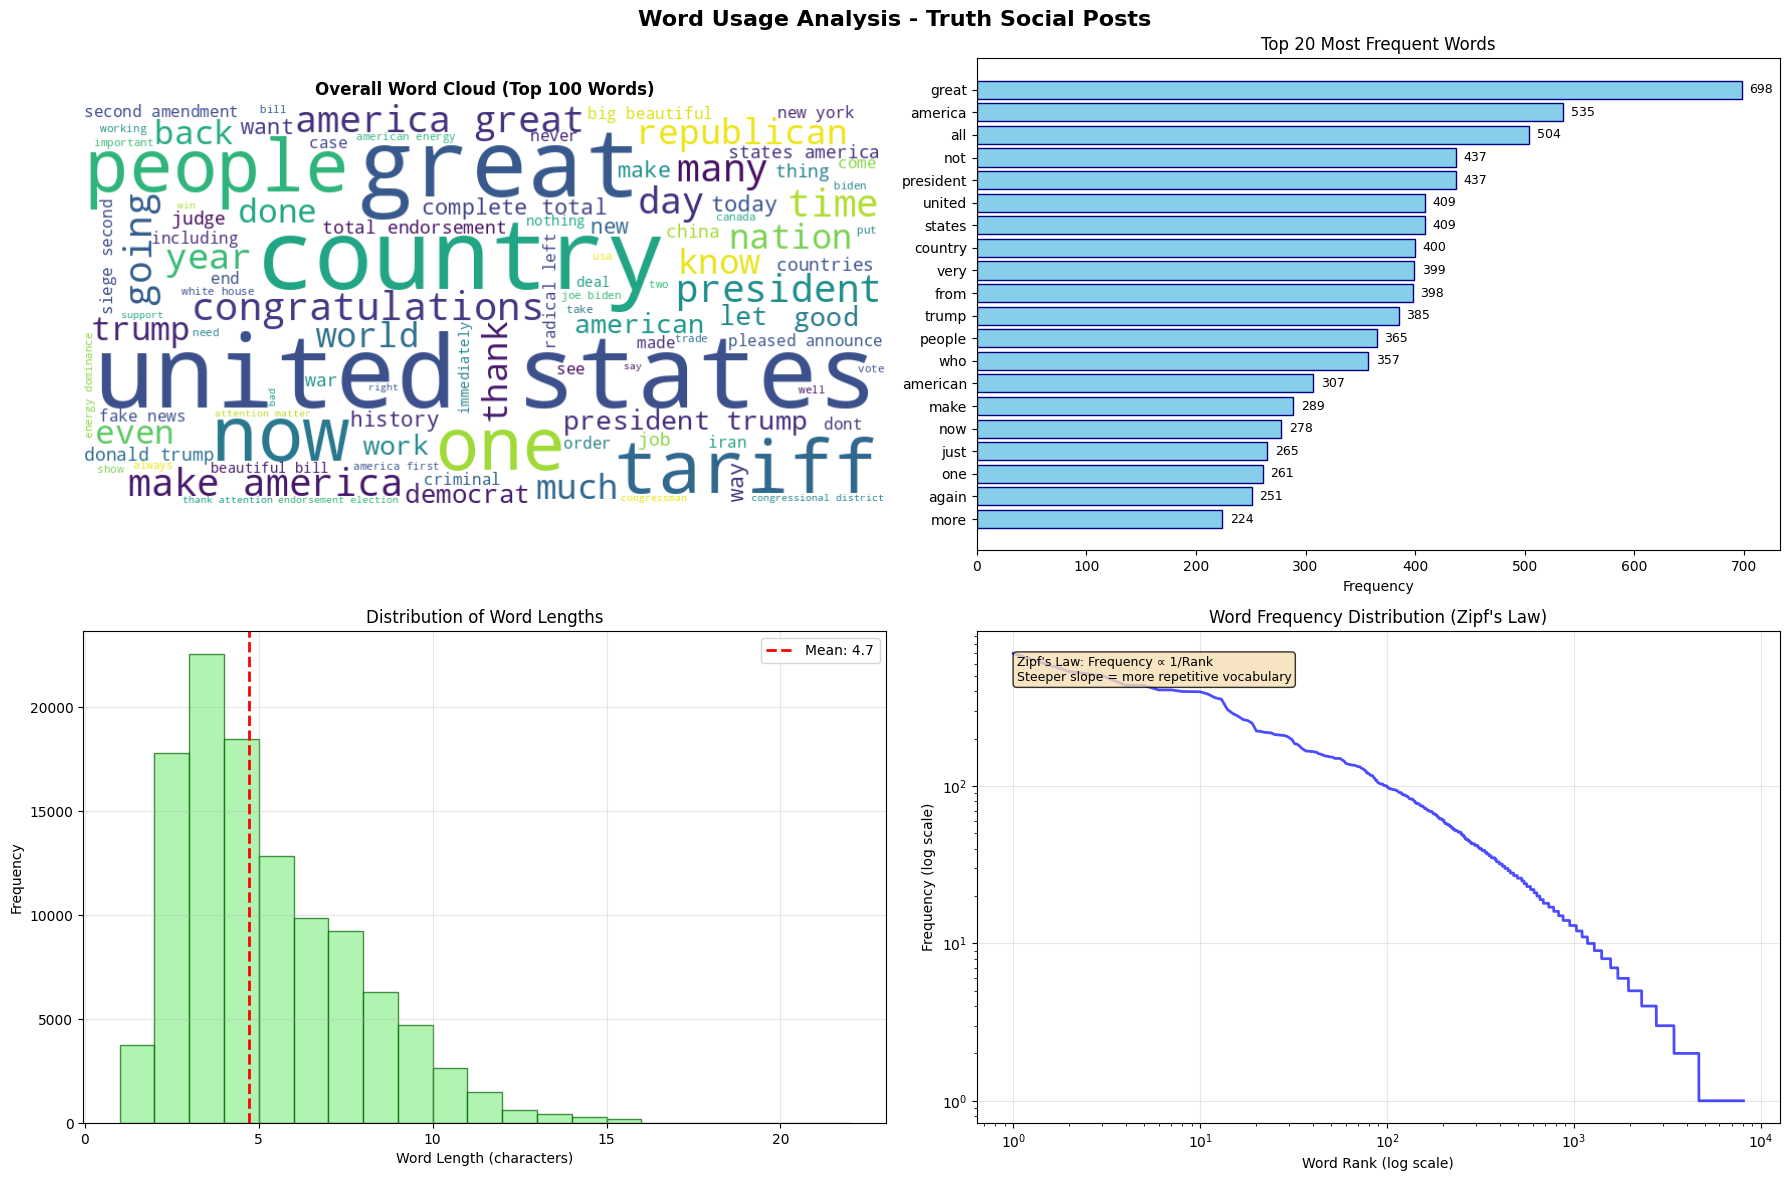

In [375]:
# Create word clouds and frequency visualizations
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle('Word Usage Analysis - Truth Social Posts', fontsize=16, fontweight='bold')

# 1. Overall word cloud
print("Generating word clouds...")

# Prepare text for word cloud (remove stopwords)
wordcloud_text = ' '.join([word for word in words if word not in basic_stopwords and len(word) > 2])

try:
    wordcloud = WordCloud(width=800, height=400, 
                         background_color='white',
                         max_words=100,
                         colormap='viridis',
                         relative_scaling=0.5).generate(wordcloud_text)
    
    axes[0,0].imshow(wordcloud, interpolation='bilinear')
    axes[0,0].set_title('Overall Word Cloud (Top 100 Words)', fontsize=12, fontweight='bold')
    axes[0,0].axis('off')
except Exception as e:
    axes[0,0].text(0.5, 0.5, f'Word cloud generation failed:\n{str(e)}', 
                   ha='center', va='center', transform=axes[0,0].transAxes)
    axes[0,0].set_title('Overall Word Cloud (Error)')

# 2. Top word frequency bar chart
top_words = Counter(filtered_words).most_common(20)
words_list, counts_list = zip(*top_words)

bars = axes[0,1].barh(range(len(words_list)), counts_list, color='skyblue', edgecolor='navy')
axes[0,1].set_yticks(range(len(words_list)))
axes[0,1].set_yticklabels(words_list)
axes[0,1].set_xlabel('Frequency')
axes[0,1].set_title('Top 20 Most Frequent Words')
axes[0,1].invert_yaxis()  # Most frequent at top

# Add frequency labels on bars
for i, (bar, count) in enumerate(zip(bars, counts_list)):
    axes[0,1].text(bar.get_width() + max(counts_list)*0.01, bar.get_y() + bar.get_height()/2, 
                   str(count), ha='left', va='center', fontsize=9)

# 3. Word length distribution
axes[1,0].hist(word_lengths, bins=range(1, max(word_lengths)+2), alpha=0.7, color='lightgreen', edgecolor='darkgreen')
axes[1,0].axvline(np.mean(word_lengths), color='red', linestyle='--', linewidth=2, 
                  label=f'Mean: {np.mean(word_lengths):.1f}')
axes[1,0].set_xlabel('Word Length (characters)')
axes[1,0].set_ylabel('Frequency')
axes[1,0].set_title('Distribution of Word Lengths')
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

# 4. Word frequency distribution (Zipf's law visualization)
word_ranks = list(range(1, len(filtered_words) + 1))
word_counts_sorted = sorted(filtered_words.values(), reverse=True)

axes[1,1].loglog(word_ranks, word_counts_sorted, 'b-', alpha=0.7, linewidth=2)
axes[1,1].set_xlabel('Word Rank (log scale)')
axes[1,1].set_ylabel('Frequency (log scale)')
axes[1,1].set_title('Word Frequency Distribution (Zipf\'s Law)')
axes[1,1].grid(True, alpha=0.3)

# Add annotation about Zipf's law
axes[1,1].text(0.05, 0.95, "Zipf's Law: Frequency ∝ 1/Rank\nSteeper slope = more repetitive vocabulary", 
               transform=axes[1,1].transAxes, bbox=dict(boxstyle="round", facecolor='wheat', alpha=0.8),
               verticalalignment='top', fontsize=9)

plt.tight_layout()
plt.savefig('../images/eda_figure_04.svg', format='svg', bbox_inches='tight', dpi=300)
plt.show()


In [376]:
# Analyze distinctive linguistic patterns and characteristics
print("=== DISTINCTIVE LINGUISTIC PATTERNS ===\n")

# Function to analyze special patterns in text
def analyze_linguistic_patterns(text):
    if not text:
        return {}
    
    import re
    
    patterns = {
        'all_caps_words': len(re.findall(r'\b[A-Z]{2,}\b', text)),  # ALL CAPS words
        'exclamation_marks': text.count('!'),
        'question_marks': text.count('?'),
        'quotation_marks': text.count('"') + text.count("'"),
        'ellipsis': len(re.findall(r'\.{2,}', text)),  # Multiple dots
        'repetitive_letters': len(re.findall(r'(.)\1{2,}', text)),  # Like "sooo" or "!!!!"
        'numbers': len(re.findall(r'\b\d+\b', text)),
        'parentheses': text.count('(') + text.count(')'),
        'capitalized_words': len(re.findall(r'\b[A-Z][a-z]+\b', text)),
    }
    
    # Calculate intensifiers and superlatives
    intensifiers = ['very', 'extremely', 'incredibly', 'absolutely', 'totally', 'completely', 'really', 'truly', 'quite', 'rather', 'highly', 'utterly', 'perfectly', 'entirely']
    superlatives = ['best', 'worst', 'greatest', 'biggest', 'largest', 'smallest', 'fastest', 'slowest', 'strongest', 'weakest', 'most', 'least', 'first', 'last', 'top', 'bottom']
    
    text_lower = text.lower()
    patterns['intensifiers'] = sum(text_lower.count(word) for word in intensifiers)
    patterns['superlatives'] = sum(text_lower.count(word) for word in superlatives)
    
    return patterns

# Analyze patterns for all posts
print("Analyzing linguistic patterns...")
pattern_data = []
for text in word_analysis_df['word_analysis_text']:
    patterns = analyze_linguistic_patterns(text)
    pattern_data.append(patterns)

# Convert to DataFrame for analysis
patterns_df = pd.DataFrame(pattern_data)

print("LINGUISTIC PATTERN STATISTICS:")
print("="*50)

for pattern in patterns_df.columns:
    total = patterns_df[pattern].sum()
    posts_with_pattern = (patterns_df[pattern] > 0).sum()
    avg_per_post = patterns_df[pattern].mean()
    max_in_post = patterns_df[pattern].max()
    
    print(f"{pattern.replace('_', ' ').title()}:")
    print(f"  Total occurrences: {total}")
    print(f"  Posts containing: {posts_with_pattern} ({posts_with_pattern/len(patterns_df)*100:.1f}%)")
    print(f"  Average per post: {avg_per_post:.2f}")
    print(f"  Maximum in single post: {max_in_post}")
    print()

# Find posts with extreme patterns
print("POSTS WITH EXTREME PATTERNS:")
print("="*50)

# Most ALL CAPS words
most_caps_idx = patterns_df['all_caps_words'].idxmax()
if patterns_df.loc[most_caps_idx, 'all_caps_words'] > 0:
    most_caps_text = word_analysis_df.iloc[most_caps_idx]['word_analysis_text']
    print(f"Most ALL CAPS words ({patterns_df.loc[most_caps_idx, 'all_caps_words']}):")
    print(f"'{most_caps_text[:200]}...'" if len(most_caps_text) > 200 else f"'{most_caps_text}'")
    print()

# Most exclamation marks
most_exclaim_idx = patterns_df['exclamation_marks'].idxmax()
if patterns_df.loc[most_exclaim_idx, 'exclamation_marks'] > 0:
    most_exclaim_text = word_analysis_df.iloc[most_exclaim_idx]['word_analysis_text']
    print(f"Most exclamation marks ({patterns_df.loc[most_exclaim_idx, 'exclamation_marks']}):")
    print(f"'{most_exclaim_text[:200]}...'" if len(most_exclaim_text) > 200 else f"'{most_exclaim_text}'")
    print()

# Most superlatives
most_super_idx = patterns_df['superlatives'].idxmax()
if patterns_df.loc[most_super_idx, 'superlatives'] > 0:
    most_super_text = word_analysis_df.iloc[most_super_idx]['word_analysis_text']
    print(f"Most superlatives ({patterns_df.loc[most_super_idx, 'superlatives']}):")
    print(f"'{most_super_text[:200]}...'" if len(most_super_text) > 200 else f"'{most_super_text}'")
    print()


=== DISTINCTIVE LINGUISTIC PATTERNS ===

Analyzing linguistic patterns...
LINGUISTIC PATTERN STATISTICS:
All Caps Words:
  Total occurrences: 9715
  Posts containing: 1272 (69.1%)
  Average per post: 5.27
  Maximum in single post: 169

Exclamation Marks:
  Total occurrences: 2653
  Posts containing: 1350 (73.3%)
  Average per post: 1.44
  Maximum in single post: 19

Question Marks:
  Total occurrences: 180
  Posts containing: 97 (5.3%)
  Average per post: 0.10
  Maximum in single post: 7

Quotation Marks:
  Total occurrences: 384
  Posts containing: 195 (10.6%)
  Average per post: 0.21
  Maximum in single post: 6

Ellipsis:
  Total occurrences: 77
  Posts containing: 61 (3.3%)
  Average per post: 0.04
  Maximum in single post: 3

Repetitive Letters:
  Total occurrences: 471
  Posts containing: 384 (20.8%)
  Average per post: 0.26
  Maximum in single post: 6

Numbers:
  Total occurrences: 914
  Posts containing: 434 (23.6%)
  Average per post: 0.50
  Maximum in single post: 10

Parenthe

=== WORD USAGE BY SENTIMENT CATEGORY ===

POSITIVE POSTS (1184 posts):
----------------------------------------
Total words: 46,339
Unique words: 6,505
Top 15 words:
   1. great        |  616 times (1.33%)
   2. america      |  410 times (0.88%)
   3. united       |  340 times (0.73%)
   4. all          |  339 times (0.73%)
   5. states       |  334 times (0.72%)
   6. very         |  295 times (0.64%)
   7. president    |  283 times (0.61%)
   8. from         |  263 times (0.57%)
   9. not          |  258 times (0.56%)
  10. american     |  247 times (0.53%)
  11. country      |  244 times (0.53%)
  12. people       |  235 times (0.51%)
  13. make         |  223 times (0.48%)
  14. trump        |  223 times (0.48%)
  15. who          |  220 times (0.47%)

NEGATIVE POSTS (436 posts):
----------------------------------------
Total words: 18,973
Unique words: 4,078
Top 15 words:
   1. not          |  174 times (0.92%)
   2. country      |  154 times (0.81%)
   3. all          |  154 time

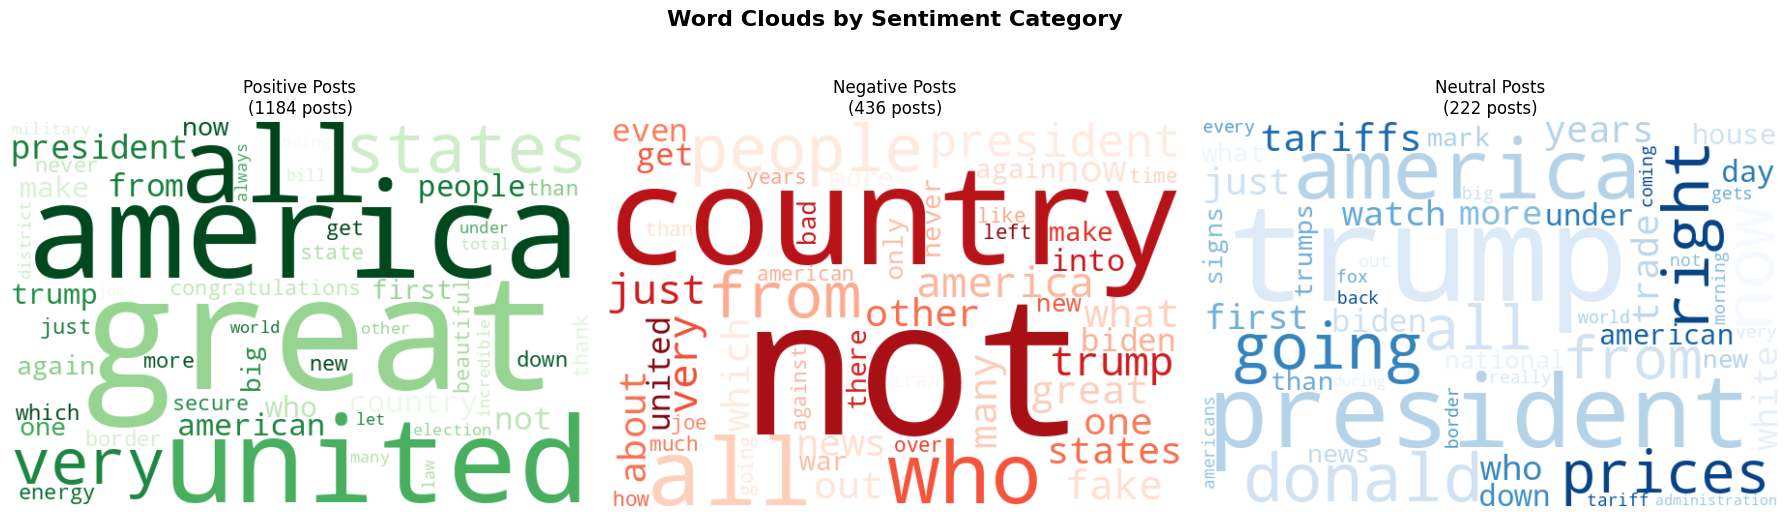

In [377]:
# Compare word usage by sentiment category
if 'sentiment_df' in locals() and len(sentiment_df) > 0:
    print("=== WORD USAGE BY SENTIMENT CATEGORY ===\n")
    
    # Merge word analysis with sentiment analysis
    combined_word_sentiment = word_analysis_df.join(sentiment_df[['sentiment_category', 'vader_compound']], how='inner')
    
    # Analyze words by sentiment
    sentiment_word_analysis = {}
    for sentiment in ['Positive', 'Negative', 'Neutral']:
        sentiment_posts = combined_word_sentiment[combined_word_sentiment['sentiment_category'] == sentiment]
        if len(sentiment_posts) > 0:
            # Combine all text for this sentiment
            sentiment_text = ' '.join(sentiment_posts['word_analysis_text'].dropna())
            sentiment_words = re.findall(r'\b[a-zA-Z]+\b', sentiment_text.lower())
            sentiment_words_filtered = [word for word in sentiment_words if word not in basic_stopwords and len(word) > 2]
            sentiment_word_freq = Counter(sentiment_words_filtered)
            sentiment_word_analysis[sentiment] = {
                'word_freq': sentiment_word_freq,
                'total_words': len(sentiment_words_filtered),
                'unique_words': len(sentiment_word_freq),
                'post_count': len(sentiment_posts)
            }
    
    # Display word analysis by sentiment
    for sentiment, data in sentiment_word_analysis.items():
        print(f"{sentiment.upper()} POSTS ({data['post_count']} posts):")
        print("-" * 40)
        print(f"Total words: {data['total_words']:,}")
        print(f"Unique words: {data['unique_words']:,}")
        print(f"Top 15 words:")
        for i, (word, count) in enumerate(data['word_freq'].most_common(15), 1):
            percentage = (count / data['total_words']) * 100
            print(f"  {i:2d}. {word:<12} | {count:4d} times ({percentage:.2f}%)")
        print()
    
    # Find distinctive words for each sentiment (words that appear more in one sentiment vs others)
    print("DISTINCTIVE WORDS BY SENTIMENT:")
    print("="*50)
    
    for target_sentiment in ['Positive', 'Negative']:
        if target_sentiment in sentiment_word_analysis:
            target_freq = sentiment_word_analysis[target_sentiment]['word_freq']
            
            # Compare with other sentiments
            other_sentiments = [s for s in sentiment_word_analysis.keys() if s != target_sentiment]
            other_total_words = sum(sentiment_word_analysis[s]['total_words'] for s in other_sentiments)
            
            distinctive_words = []
            for word, count in target_freq.most_common(100):  # Check top 100 words
                if count >= 3:  # Only consider words that appear at least 3 times
                    target_rate = count / sentiment_word_analysis[target_sentiment]['total_words']
                    
                    # Calculate rate in other sentiments
                    other_count = sum(sentiment_word_analysis[s]['word_freq'].get(word, 0) for s in other_sentiments)
                    other_rate = other_count / other_total_words if other_total_words > 0 else 0
                    
                    # Calculate distinctiveness ratio
                    if other_rate > 0:
                        distinctiveness = target_rate / other_rate
                        if distinctiveness > 2.0:  # Word appears at least 2x more in target sentiment
                            distinctive_words.append((word, distinctiveness, count, target_rate * 100))
            
            print(f"\n{target_sentiment.upper()}-distinctive words (appear much more in {target_sentiment.lower()} posts):")
            distinctive_words.sort(key=lambda x: x[1], reverse=True)  # Sort by distinctiveness ratio
            for i, (word, ratio, count, rate) in enumerate(distinctive_words[:10], 1):
                print(f"  {i:2d}. {word:<15} | {ratio:.1f}x more common | {count} times ({rate:.2f}%)")
    
    # Create word cloud comparison
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    fig.suptitle('Word Clouds by Sentiment Category', fontsize=16, fontweight='bold')
    
    colors = ['Greens', 'Reds', 'Blues']
    for i, (sentiment, colormap) in enumerate(zip(['Positive', 'Negative', 'Neutral'], colors)):
        if sentiment in sentiment_word_analysis:
            # Create word cloud for this sentiment
            word_freq_dict = dict(sentiment_word_analysis[sentiment]['word_freq'].most_common(50))
            
            if word_freq_dict:
                try:
                    wordcloud = WordCloud(width=600, height=400,
                                         background_color='white',
                                         max_words=50,
                                         colormap=colormap,
                                         relative_scaling=0.5).generate_from_frequencies(word_freq_dict)
                    
                    axes[i].imshow(wordcloud, interpolation='bilinear')
                    axes[i].set_title(f'{sentiment} Posts\n({sentiment_word_analysis[sentiment]["post_count"]} posts)')
                    axes[i].axis('off')
                except:
                    axes[i].text(0.5, 0.5, f'Not enough\ndata for\n{sentiment}\nword cloud', 
                               ha='center', va='center', transform=axes[i].transAxes)
                    axes[i].set_title(f'{sentiment} Posts')
            else:
                axes[i].text(0.5, 0.5, f'No words\nfound for\n{sentiment}', 
                           ha='center', va='center', transform=axes[i].transAxes)
                axes[i].set_title(f'{sentiment} Posts')
    
    plt.tight_layout()
    plt.savefig('../images/eda_figure_05.svg', format='svg', bbox_inches='tight', dpi=300)
    plt.show()
    
else:
    print("=== WORD USAGE BY SENTIMENT CATEGORY ===")
    print("Note: Run sentiment analysis first to compare word usage across different sentiment categories.")


In [378]:
# Comprehensive word analysis summary and distinctive findings
print("=== COMPREHENSIVE WORD USAGE SUMMARY ===\n")

print("📝 KEY WORD USAGE FINDINGS:")
print("="*50)

# Overall vocabulary statistics
total_unique = len(filtered_words)
vocabulary_richness = total_unique / len(words) if len(words) > 0 else 0

print(f"✓ Total vocabulary size: {total_unique:,} unique content words")
print(f"✓ Vocabulary richness: {vocabulary_richness:.3f} (unique words / total words)")
print(f"✓ Average word length: {np.mean(word_lengths):.1f} characters")

if vocabulary_richness > 0.3:
    vocab_assessment = "High vocabulary diversity"
elif vocabulary_richness > 0.2:
    vocab_assessment = "Moderate vocabulary diversity" 
else:
    vocab_assessment = "Low vocabulary diversity (repetitive)"

print(f"✓ Vocabulary assessment: {vocab_assessment}")

# Most characteristic patterns
print(f"\n📊 DISTINCTIVE LINGUISTIC CHARACTERISTICS:")
print("="*50)

if 'patterns_df' in locals():
    # Identify the most distinctive patterns
    pattern_scores = {}
    for pattern in patterns_df.columns:
        posts_with_pattern = (patterns_df[pattern] > 0).sum()
        if posts_with_pattern > 0:
            avg_per_post = patterns_df[pattern].mean()
            prevalence = posts_with_pattern / len(patterns_df)
            # Score combines frequency and prevalence
            pattern_scores[pattern] = prevalence * avg_per_post
    
    # Sort by distinctiveness
    top_patterns = sorted(pattern_scores.items(), key=lambda x: x[1], reverse=True)[:5]
    
    for i, (pattern, score) in enumerate(top_patterns, 1):
        posts_with = (patterns_df[pattern] > 0).sum()
        avg_usage = patterns_df[pattern].mean()
        prevalence_pct = (posts_with / len(patterns_df)) * 100
        
        print(f"{i}. {pattern.replace('_', ' ').title()}")
        print(f"   Used in {prevalence_pct:.1f}% of posts, averaging {avg_usage:.2f} per post")

# Top distinctive phrases
if 'bigram_freq' in locals() and len(bigram_freq) > 0:
    print(f"\n🔤 MOST CHARACTERISTIC PHRASES:")
    print("="*50)
    top_bigrams = bigram_freq.most_common(10)
    for i, (phrase, count) in enumerate(top_bigrams, 1):
        phrase_str = ' '.join(phrase)
        percentage = (count / len(all_bigrams)) * 100
        print(f"{i:2d}. '{phrase_str}' - used {count} times ({percentage:.2f}% of all phrases)")

# Zipf's law analysis
if 'word_counts_sorted' in locals():
    # Calculate how well the distribution follows Zipf's law
    # In perfect Zipf distribution, frequency * rank = constant
    zipf_products = [rank * freq for rank, freq in enumerate(word_counts_sorted[:100], 1)]
    zipf_consistency = np.std(zipf_products) / np.mean(zipf_products)  # Lower = more consistent
    
    print(f"\n📈 VOCABULARY DISTRIBUTION ANALYSIS:")
    print("="*50)
    print(f"✓ Zipf's law consistency: {zipf_consistency:.3f} (lower = more natural language patterns)")
    
    if zipf_consistency < 0.5:
        zipf_assessment = "Very natural vocabulary distribution"
    elif zipf_consistency < 1.0:
        zipf_assessment = "Fairly natural vocabulary distribution"
    else:
        zipf_assessment = "Unusual vocabulary distribution (may indicate repetitive patterns)"
    
    print(f"✓ Assessment: {zipf_assessment}")

print(f"\n💡 INTERPRETATION GUIDE:")
print("="*50)
print("VOCABULARY METRICS:")
print("• Vocabulary Richness: Higher = more diverse word usage")
print("• Word Length: Longer average = more complex vocabulary")
print("• Zipf Consistency: Lower = more natural language patterns")

print("\nLINGUISTIC PATTERNS:")
print("• ALL CAPS: Often indicates emphasis or strong emotion")
print("• Exclamation marks: Shows emotional intensity")
print("• Superlatives: Indicates strong opinions (best/worst/greatest)")
print("• Intensifiers: Adds emphasis (very/extremely/totally)")

print("\nPHRASE ANALYSIS:")
print("• Common bigrams/trigrams show recurring themes and expressions")
print("• Distinctive words by sentiment reveal emotional vocabulary")

print(f"\n🔍 SUGGESTED DEEPER ANALYSIS:")
print("="*50)
print("• Topic modeling to identify main themes")
print("• Temporal analysis of vocabulary changes over time")
print("• Comparison with other political figures' language patterns")
print("• Analysis of industry/political jargon vs. common language")
print("• Examination of borrowed phrases and original expressions")

print(f"\n💾 DATA EXPORT:")
print("Uncomment to save detailed word analysis:")
print("# word_analysis_df.to_csv('truth_social_word_analysis.csv', index=False)")
if 'patterns_df' in locals():
    print("# patterns_df.to_csv('truth_social_linguistic_patterns.csv', index=False)")

print(f"\n✅ WORD ANALYSIS COMPLETE!")
print("All word usage analysis tools and data are ready for further exploration.")


=== COMPREHENSIVE WORD USAGE SUMMARY ===

📝 KEY WORD USAGE FINDINGS:
✓ Total vocabulary size: 8,070 unique content words
✓ Vocabulary richness: 0.072 (unique words / total words)
✓ Average word length: 4.7 characters
✓ Vocabulary assessment: Low vocabulary diversity (repetitive)

📊 DISTINCTIVE LINGUISTIC CHARACTERISTICS:
1. Capitalized Words
   Used in 88.3% of posts, averaging 14.79 per post
2. All Caps Words
   Used in 69.1% of posts, averaging 5.27 per post
3. Exclamation Marks
   Used in 73.3% of posts, averaging 1.44 per post
4. Intensifiers
   Used in 33.0% of posts, averaging 0.52 per post
5. Superlatives
   Used in 33.0% of posts, averaging 0.49 per post

🔤 MOST CHARACTERISTIC PHRASES:
 1. 'united states' - used 400 times (0.61% of all phrases)
 2. 'make america' - used 159 times (0.24% of all phrases)
 3. 'great again' - used 158 times (0.24% of all phrases)
 4. 'america great' - used 150 times (0.23% of all phrases)
 5. 'complete total' - used 92 times (0.14% of all phrases)


In [379]:
# N-gram analysis to find common phrases and patterns
print("=== N-GRAM ANALYSIS (Common Phrases) ===\n")

from nltk.util import ngrams

# Function to generate n-grams
def get_ngrams(text, n):
    # Convert to lowercase and split into words
    words = text.lower().split()
    # Filter out very short words and basic stopwords for cleaner phrases
    words = [word.strip('.,!?":();[]') for word in words if len(word) > 2 and word.lower() not in basic_stopwords]
    # Generate n-grams
    return list(ngrams(words, n))

# Prepare lists for n-grams of different sizes
all_unigrams = []
all_bigrams = []
all_trigrams = []
all_fourgrams = []

for text in word_analysis_df['word_analysis_text']:
    if text:
        all_unigrams.extend(get_ngrams(text, 1))
        all_bigrams.extend(get_ngrams(text, 2))
        all_trigrams.extend(get_ngrams(text, 3))
        all_fourgrams.extend(get_ngrams(text, 4))

# Count most common phrases
unigram_freq = Counter(all_unigrams)
bigram_freq = Counter(all_bigrams)
trigram_freq = Counter(all_trigrams)
fourgram_freq = Counter(all_fourgrams)

print("TOP 20 UNIGRAMS (1-word):")
print("="*50)
for i, (phrase, count) in enumerate(unigram_freq.most_common(20), 1):
    phrase_str = ' '.join(phrase)
    percentage = (count / len(all_unigrams)) * 100
    print(f"{i:2d}. '{phrase_str:<25}' | {count:3d} times ({percentage:.2f}%)")

print("\nTOP 20 BIGRAMS (2-word phrases):")
print("="*50)
for i, (phrase, count) in enumerate(bigram_freq.most_common(20), 1):
    phrase_str = ' '.join(phrase)
    percentage = (count / len(all_bigrams)) * 100
    print(f"{i:2d}. '{phrase_str:<25}' | {count:3d} times ({percentage:.2f}%)")

print(f"\nTOP 20 TRIGRAMS (3-word phrases):")
print("="*50)
for i, (phrase, count) in enumerate(trigram_freq.most_common(20), 1):
    phrase_str = ' '.join(phrase)
    percentage = (count / len(all_trigrams)) * 100
    print(f"{i:2d}. '{phrase_str:<35}' | {count:3d} times ({percentage:.2f}%)")

print(f"\nTOP 20 FOURGRAMS (4-word phrases):")
print("="*50)
for i, (phrase, count) in enumerate(fourgram_freq.most_common(20), 1):
    phrase_str = ' '.join(phrase)
    percentage = (count / len(all_fourgrams)) * 100
    print(f"{i:2d}. '{phrase_str:<45}' | {count:3d} times ({percentage:.2f}%)")

# Analyze phrase patterns
print(f"\nPHRASE STATISTICS:")
print(f"• Total unigrams found: {len(all_unigrams):,}")
print(f"• Unique unigrams: {len(unigram_freq):,}")
print(f"• Total bigrams found: {len(all_bigrams):,}")
print(f"• Unique bigrams: {len(bigram_freq):,}")
print(f"• Total trigrams found: {len(all_trigrams):,}")
print(f"• Unique trigrams: {len(trigram_freq):,}")
print(f"• Total fourgrams found: {len(all_fourgrams):,}")
print(f"• Unique fourgrams: {len(fourgram_freq):,}")

# Find repetitive patterns (high frequency relative to uniqueness)
if len(bigram_freq) > 0:
    top_bigram_freq = bigram_freq.most_common(1)[0][1]
    repetition_ratio = top_bigram_freq / len(bigram_freq)
    print(f"• Bigram repetition ratio: {repetition_ratio:.4f} (higher = more repetitive)")


=== N-GRAM ANALYSIS (Common Phrases) ===

TOP 20 UNIGRAMS (1-word):
 1. 'great                    ' | 697 times (1.01%)
 2. 'america                  ' | 523 times (0.76%)
 3. 'all                      ' | 493 times (0.72%)
 4. 'not                      ' | 437 times (0.63%)
 5. 'president                ' | 421 times (0.61%)
 6. 'united                   ' | 409 times (0.59%)
 7. 'states                   ' | 405 times (0.59%)
 8. 'very                     ' | 399 times (0.58%)
 9. 'from                     ' | 397 times (0.58%)
10. 'country                  ' | 394 times (0.57%)
11. 'people                   ' | 362 times (0.53%)
12. 'who                      ' | 355 times (0.52%)
13. 'trump                    ' | 349 times (0.51%)
14. 'american                 ' | 298 times (0.43%)
15. 'make                     ' | 289 times (0.42%)
16. 'now                      ' | 276 times (0.40%)
17. 'just                     ' | 265 times (0.38%)
18. 'one                      ' | 256 times (0.3

In [380]:
# ============================================================================
# TEMPORAL PHRASE FREQUENCY ANALYSIS
# ============================================================================
print("=== TEMPORAL PHRASE FREQUENCY ANALYSIS ===\n")

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta
import numpy as np

# Ensure we have the necessary data
if 'word_analysis_df' not in locals() or word_analysis_df.empty:
    print("Error: word_analysis_df not found. Please run the word analysis section first.")
else:
    print(f"Analyzing temporal patterns in {len(word_analysis_df)} posts")
    
    # First, ensure date_parsed is in datetime format
    print("Converting date_parsed to datetime format...")
    word_analysis_df['date_parsed'] = pd.to_datetime(word_analysis_df['date_parsed'])
    print(f"Date range: {word_analysis_df['date_parsed'].min()} to {word_analysis_df['date_parsed'].max()}")
    
    # Create time-based groupings (weekly bins)
    word_analysis_df['week_start'] = word_analysis_df['date_parsed'].dt.to_period('W').dt.start_time
    print(f"Time span: {word_analysis_df['week_start'].nunique()} weeks")


=== TEMPORAL PHRASE FREQUENCY ANALYSIS ===

Analyzing temporal patterns in 1842 posts
Converting date_parsed to datetime format...
Date range: 2025-01-01 10:48:00 to 2025-07-20 20:53:00
Time span: 29 weeks


In [381]:
# Import additional libraries needed for temporal analysis
import re
from collections import Counter
from nltk.util import ngrams

# Function to get temporal n-grams with better filtering
def get_temporal_ngrams(texts, n, min_length=3):
    """Generate n-grams from texts with improved filtering"""
    all_ngrams = []
    
    for text in texts:
        if pd.isna(text) or not text.strip():
            continue
        
        # Clean and tokenize
        words = text.lower().split()
        # Enhanced filtering: remove short words, common words, and clean punctuation
        filtered_words = []
        
        for word in words:
            # Remove punctuation and clean
            clean_word = re.sub(r'[^\w]', '', word)
            
            # Skip if too short, all digits, or common stopwords
            if (len(clean_word) >= min_length and 
                not clean_word.isdigit() and
                clean_word.lower() not in ['the', 'and', 'for', 'are', 'but', 'not', 'you', 'all', 
                                         'can', 'her', 'was', 'one', 'our', 'had', 'have', 'what',
                                         'said', 'there', 'each', 'which', 'their', 'time', 'will',
                                         'about', 'would', 'been', 'from', 'they', 'more', 'very',
                                         'into', 'after', 'just', 'only', 'over', 'also', 'back',
                                         'other', 'many', 'then', 'them', 'these', 'some', 'like']):
                filtered_words.append(clean_word)
        
        # Generate n-grams
        if len(filtered_words) >= n:
            all_ngrams.extend(list(ngrams(filtered_words, n)))
    
    return all_ngrams

# Get overall top phrases across all time periods
print("Identifying top phrases across all data...")

# Generate all n-grams
print("Processing 1-grams (individual words)...")
all_unigrams = get_temporal_ngrams(word_analysis_df['word_analysis_text'], 1)
unigram_counter = Counter(all_unigrams)

print("Processing 2-grams (2-word phrases)...")
all_bigrams = get_temporal_ngrams(word_analysis_df['word_analysis_text'], 2)
bigram_counter = Counter(all_bigrams)

print("Processing 3-grams (3-word phrases)...")
all_trigrams = get_temporal_ngrams(word_analysis_df['word_analysis_text'], 3)
trigram_counter = Counter(all_trigrams)

print("Processing 4-grams (4-word phrases)...")
all_fourgrams = get_temporal_ngrams(word_analysis_df['word_analysis_text'], 4)
fourgram_counter = Counter(all_fourgrams)

# Get top 20 of each type
top_unigrams = [phrase[0] for phrase, count in unigram_counter.most_common(20)]
top_bigrams = [' '.join(phrase) for phrase, count in bigram_counter.most_common(20)]
top_trigrams = [' '.join(phrase) for phrase, count in trigram_counter.most_common(20)]
top_fourgrams = [' '.join(phrase) for phrase, count in fourgram_counter.most_common(20)]

print(f"\nTop phrase statistics:")
print(f"• Total unique unigrams: {len(unigram_counter):,}")
print(f"• Total unique bigrams: {len(bigram_counter):,}")
print(f"• Total unique trigrams: {len(trigram_counter):,}")
print(f"• Total unique fourgrams: {len(fourgram_counter):,}")

print(f"\nTop 10 words: {', '.join(top_unigrams[:10])}")
print(f"Top 5 bigrams: {', '.join(top_bigrams[:5])}")
print(f"Top 5 trigrams: {', '.join(top_trigrams[:5])}")
print(f"Top 3 fourgrams: {', '.join(top_fourgrams[:3])}")


Identifying top phrases across all data...
Processing 1-grams (individual words)...
Processing 2-grams (2-word phrases)...
Processing 3-grams (3-word phrases)...
Processing 4-grams (4-word phrases)...

Top phrase statistics:
• Total unique unigrams: 8,644
• Total unique bigrams: 44,505
• Total unique trigrams: 53,773
• Total unique fourgrams: 54,980

Top 10 words: that, this, great, with, has, america, president, united, states, country
Top 5 bigrams: united states, make america, great again, america great, complete total
Top 5 trigrams: america great again, make america great, has complete total, complete total endorsement, united states america
Top 3 fourgrams: make america great again, has complete total endorsement, always under siege second


In [382]:
# Function to track phrase frequencies over time
def track_phrases_over_time(df, phrases, ngram_size, phrase_type="phrases"):
    """Track how specific phrases change in frequency over time periods"""
    
    # Group by time period
    time_groups = df.groupby('week_start')
    time_series_data = {}
    
    # Initialize data structure
    all_weeks = sorted(df['week_start'].unique())
    for phrase in phrases:
        time_series_data[phrase] = {week: 0 for week in all_weeks}
    
    print(f"Tracking {len(phrases)} top {phrase_type} across {len(all_weeks)} weeks...")
    
    # For each time period, count phrase frequencies
    for week, group in time_groups:
        if len(group) == 0:
            continue
            
        # Get all texts for this week
        week_texts = group['word_analysis_text'].dropna()
        if len(week_texts) == 0:
            continue
        
        # Generate n-grams for this week
        week_ngrams = get_temporal_ngrams(week_texts, ngram_size)
        week_counter = Counter(week_ngrams)
        
        # Count occurrences of our target phrases
        for phrase in phrases:
            if ngram_size == 1:
                # For unigrams, phrase is already a string
                phrase_tuple = (phrase,)
            else:
                # For n-grams, convert back to tuple
                phrase_tuple = tuple(phrase.split())
            
            count = week_counter.get(phrase_tuple, 0)
            time_series_data[phrase][week] = count
    
    return time_series_data, all_weeks

# Track each phrase type over time
print("\n" + "="*60)
print("TRACKING PHRASE FREQUENCIES OVER TIME")
print("="*60)

unigram_data, weeks = track_phrases_over_time(word_analysis_df, top_unigrams, 1, "words")
bigram_data, _ = track_phrases_over_time(word_analysis_df, top_bigrams, 2, "2-word phrases")  
trigram_data, _ = track_phrases_over_time(word_analysis_df, top_trigrams, 3, "3-word phrases")
fourgram_data, _ = track_phrases_over_time(word_analysis_df, top_fourgrams, 4, "4-word phrases")

print(f"\nCompleted temporal analysis for {len(weeks)} time periods")



TRACKING PHRASE FREQUENCIES OVER TIME
Tracking 20 top words across 29 weeks...
Tracking 20 top 2-word phrases across 29 weeks...
Tracking 20 top 3-word phrases across 29 weeks...
Tracking 20 top 4-word phrases across 29 weeks...

Completed temporal analysis for 29 time periods



CREATING TEMPORAL VISUALIZATIONS


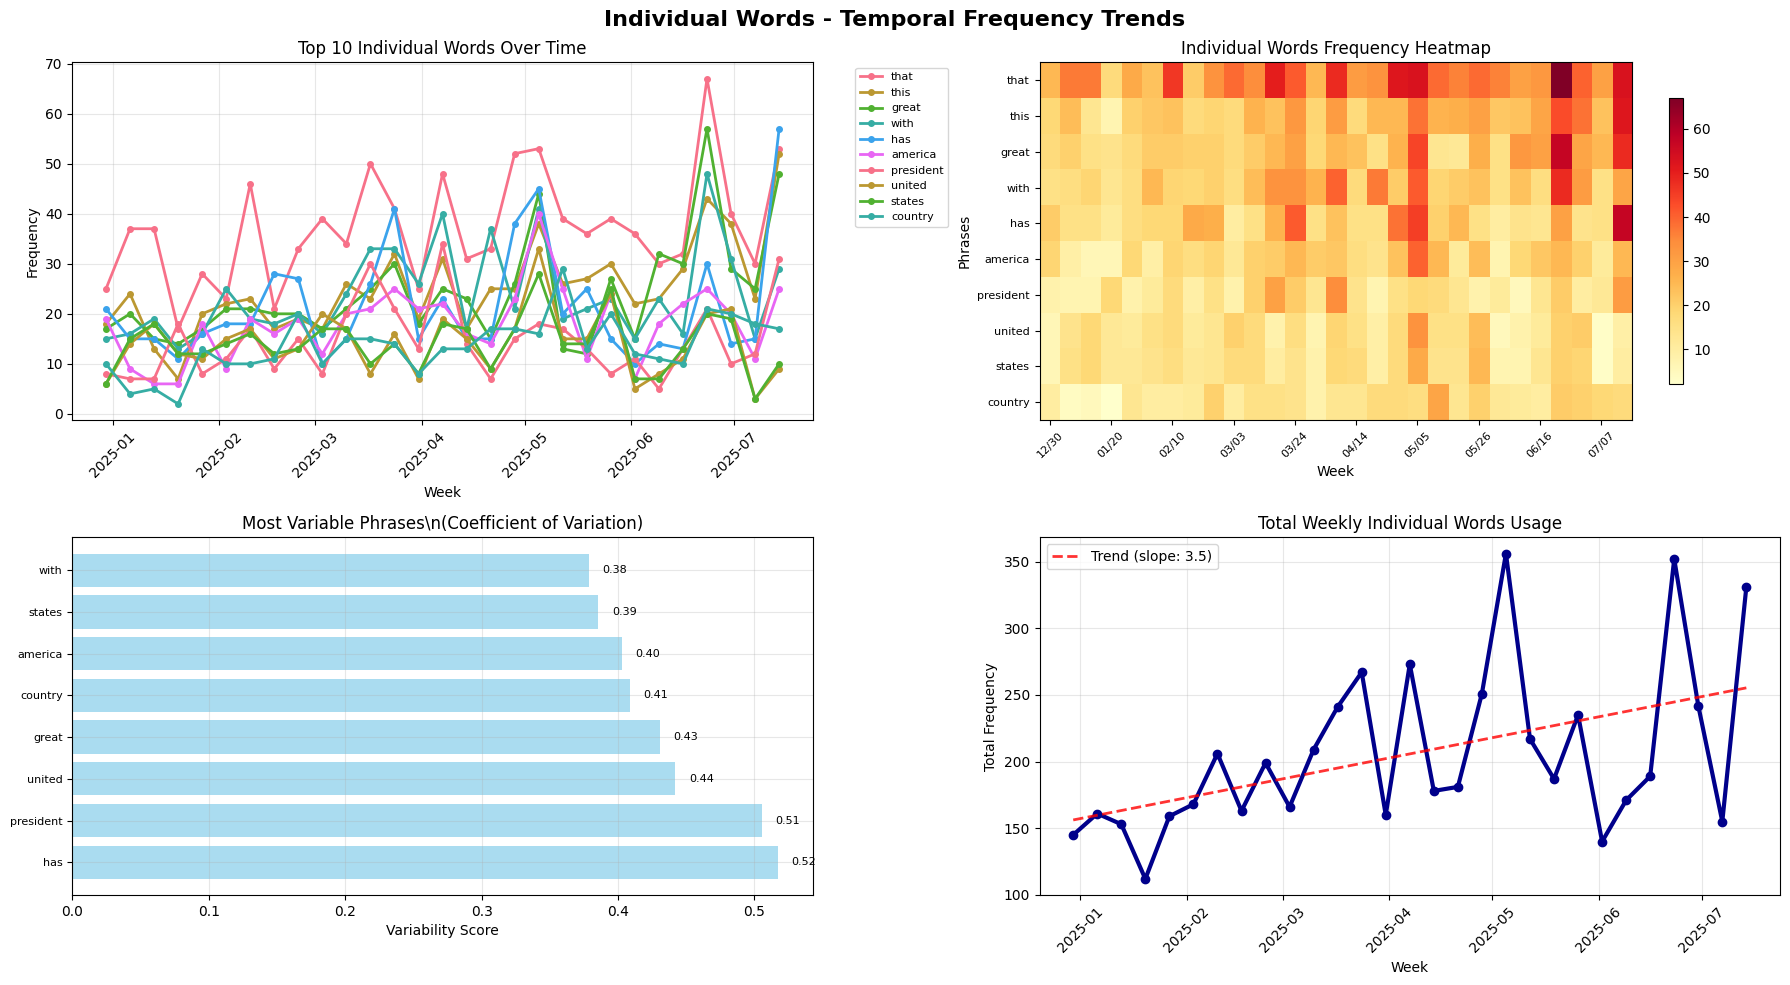

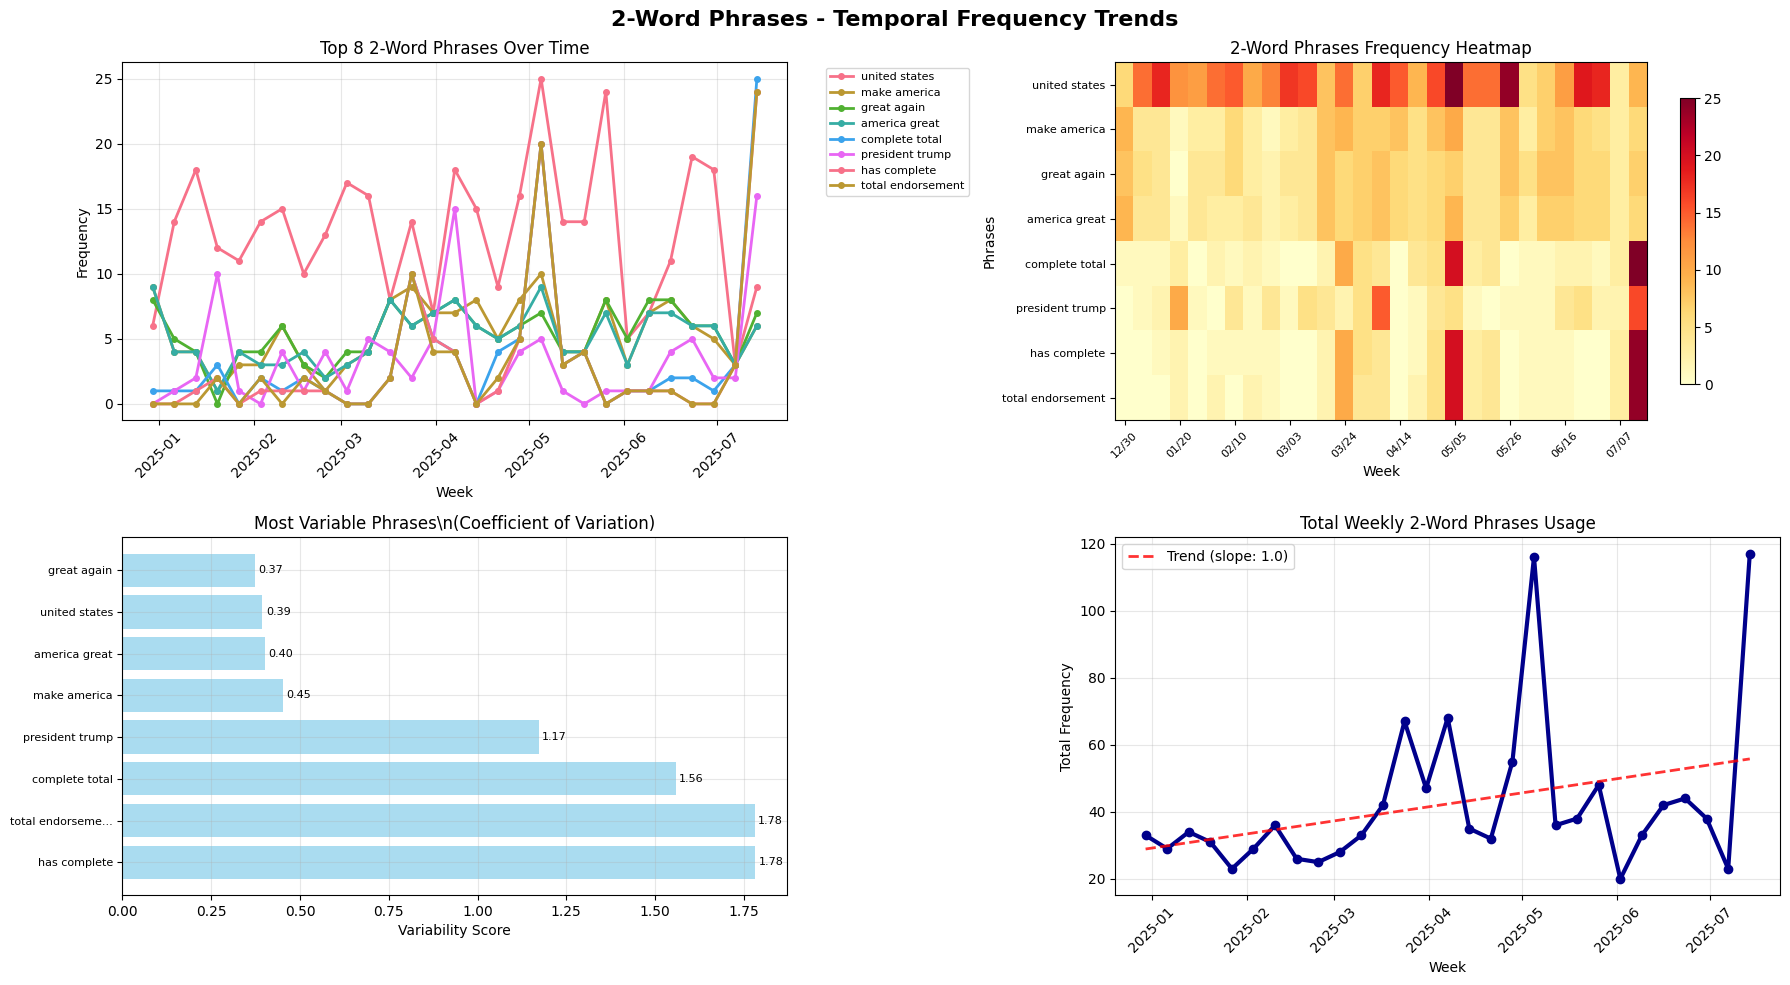

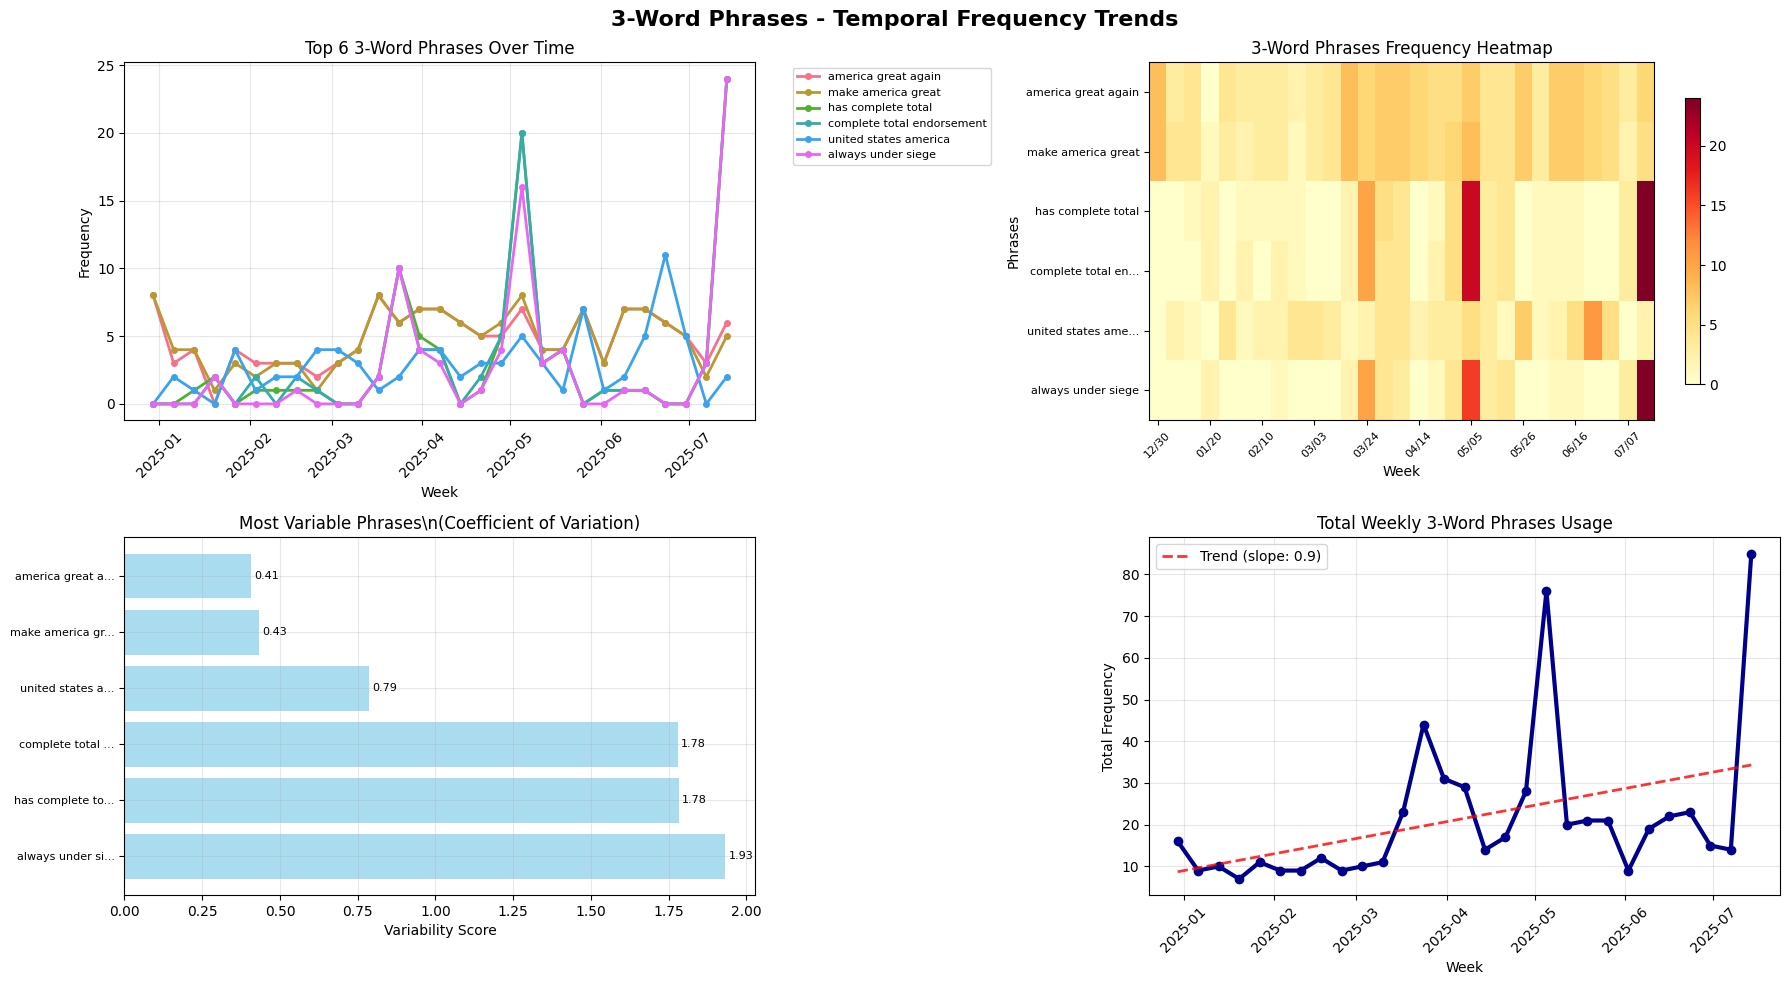

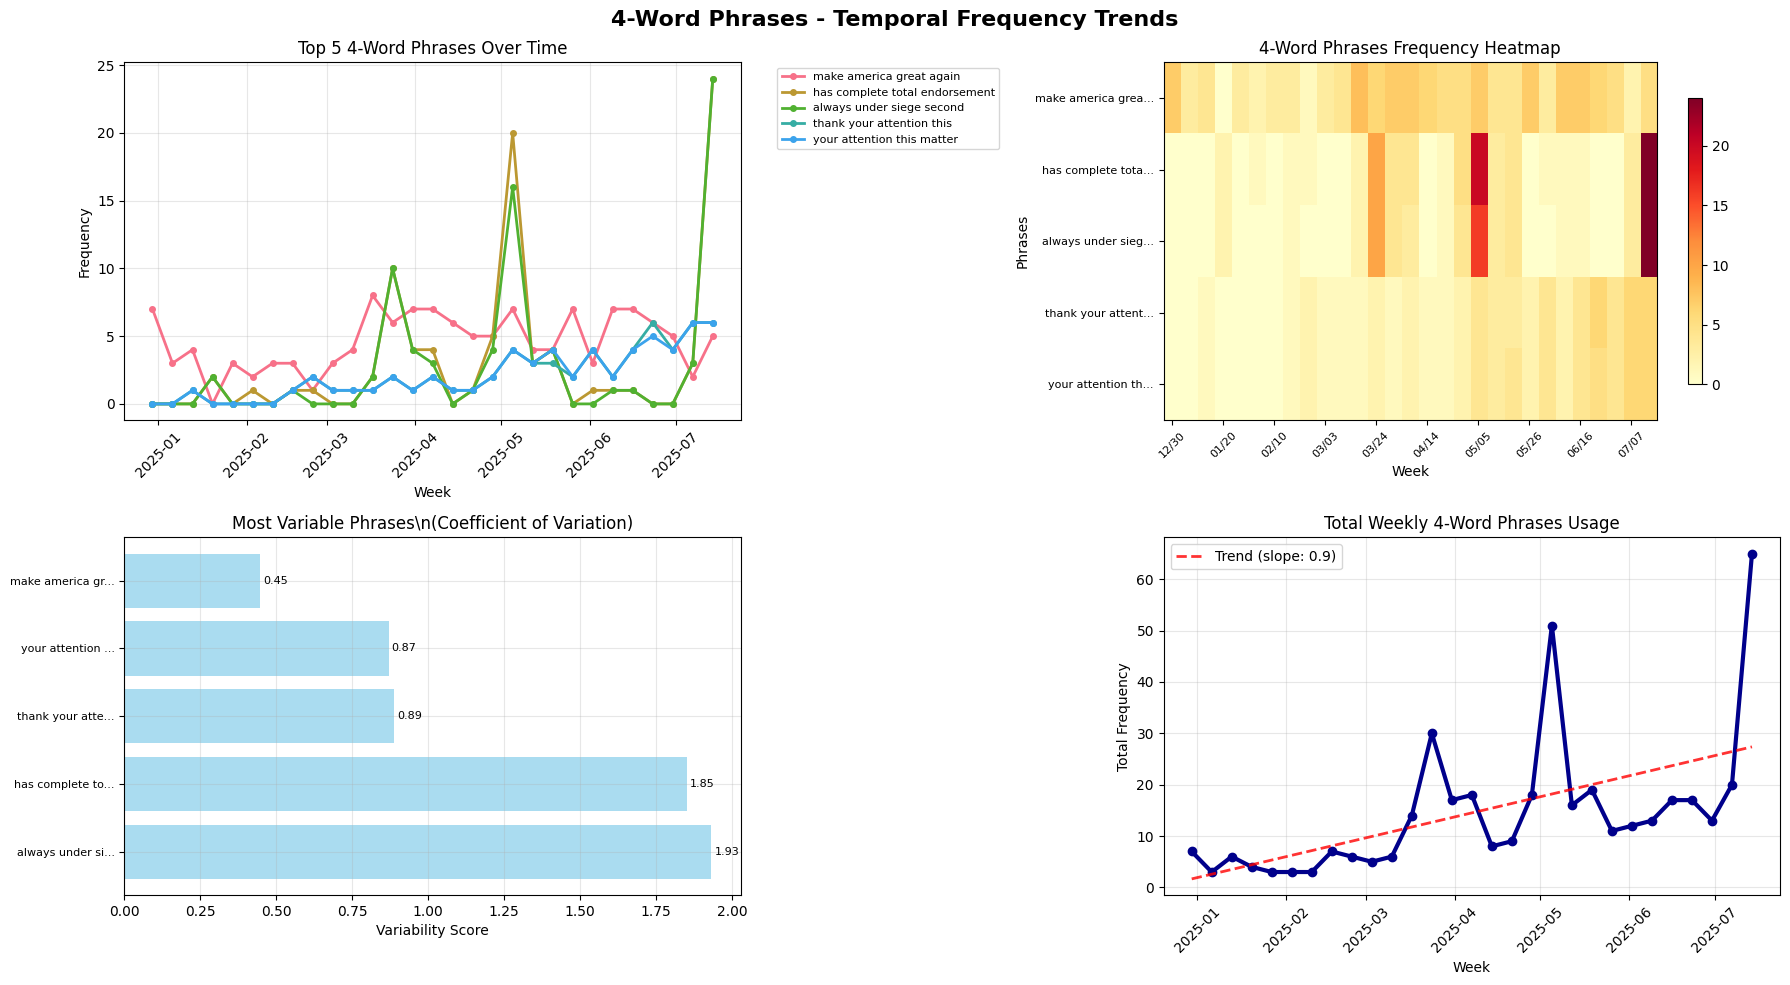

In [383]:
# Create comprehensive temporal visualizations
def plot_temporal_trends(data_dict, weeks, title, top_n=10, figsize=(18, 10)):
    """Create temporal trend plots for phrases"""
    
    fig, axes = plt.subplots(2, 2, figsize=figsize)
    fig.suptitle(f'{title} - Temporal Frequency Trends', fontsize=16, fontweight='bold')
    
    # Convert weeks to datetime for better plotting
    week_dates = pd.to_datetime(weeks)
    
    # Plot 1: Top phrases over time (line plot)
    ax1 = axes[0, 0]
    phrases_to_plot = list(data_dict.keys())[:top_n]
    
    for phrase in phrases_to_plot:
        frequencies = [data_dict[phrase][week] for week in weeks]
        ax1.plot(week_dates, frequencies, marker='o', linewidth=2, markersize=4, label=phrase)
    
    ax1.set_title(f'Top {top_n} {title} Over Time')
    ax1.set_xlabel('Week')
    ax1.set_ylabel('Frequency')
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
    ax1.grid(True, alpha=0.3)
    ax1.tick_params(axis='x', rotation=45)
    
    # Plot 2: Heatmap of phrase frequencies
    ax2 = axes[0, 1]
    
    # Create heatmap data
    heatmap_data = []
    phrase_labels = []
    
    for phrase in phrases_to_plot:
        frequencies = [data_dict[phrase][week] for week in weeks]
        heatmap_data.append(frequencies)
        # Truncate long phrases for display
        display_phrase = phrase if len(phrase) <= 20 else phrase[:17] + "..."
        phrase_labels.append(display_phrase)
    
    if heatmap_data:
        im = ax2.imshow(heatmap_data, cmap='YlOrRd', aspect='auto')
        ax2.set_title(f'{title} Frequency Heatmap')
        ax2.set_xlabel('Week')
        ax2.set_ylabel('Phrases')
        ax2.set_yticks(range(len(phrase_labels)))
        ax2.set_yticklabels(phrase_labels, fontsize=8)
        
        # Set x-axis to show week dates
        week_labels = [week.strftime('%m/%d') for week in week_dates[::max(1, len(week_dates)//8)]]
        ax2.set_xticks(range(0, len(weeks), max(1, len(weeks)//8)))
        ax2.set_xticklabels(week_labels, rotation=45, fontsize=8)
        
        # Add colorbar
        plt.colorbar(im, ax=ax2, shrink=0.8)
    
    # Plot 3: Most variable phrases (coefficient of variation)
    ax3 = axes[1, 0]
    
    variability_scores = []
    phrase_names = []
    
    for phrase in phrases_to_plot:
        frequencies = [data_dict[phrase][week] for week in weeks]
        if sum(frequencies) > 0:  # Only calculate for phrases that appear
            mean_freq = np.mean(frequencies)
            std_freq = np.std(frequencies)
            cv = std_freq / mean_freq if mean_freq > 0 else 0
            variability_scores.append(cv)
            phrase_names.append(phrase[:15] + "..." if len(phrase) > 15 else phrase)
    
    if variability_scores:
        sorted_data = sorted(zip(variability_scores, phrase_names), reverse=True)[:8]
        scores, names = zip(*sorted_data)
        
        bars = ax3.barh(range(len(names)), scores, color='skyblue', alpha=0.7)
        ax3.set_title('Most Variable Phrases\\n(Coefficient of Variation)')
        ax3.set_xlabel('Variability Score')
        ax3.set_yticks(range(len(names)))
        ax3.set_yticklabels(names, fontsize=8)
        ax3.grid(True, alpha=0.3)
        
        # Add value labels on bars
        for i, (bar, score) in enumerate(zip(bars, scores)):
            ax3.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2, 
                    f'{score:.2f}', va='center', fontsize=8)
    
    # Plot 4: Weekly totals and trending phrases
    ax4 = axes[1, 1]
    
    # Calculate total phrase usage per week
    weekly_totals = []
    for week in weeks:
        total = sum(data_dict[phrase][week] for phrase in phrases_to_plot)
        weekly_totals.append(total)
    
    ax4.plot(week_dates, weekly_totals, marker='o', linewidth=3, markersize=6, color='darkblue')
    ax4.set_title(f'Total Weekly {title} Usage')
    ax4.set_xlabel('Week')  
    ax4.set_ylabel('Total Frequency')
    ax4.grid(True, alpha=0.3)
    ax4.tick_params(axis='x', rotation=45)
    
    # Add trend line
    x_numeric = range(len(weekly_totals))
    z = np.polyfit(x_numeric, weekly_totals, 1)
    p = np.poly1d(z)
    ax4.plot(week_dates, p(x_numeric), "r--", alpha=0.8, linewidth=2, label=f'Trend (slope: {z[0]:.1f})')
    ax4.legend()
    
    plt.tight_layout()
    return fig

# Create visualizations for each phrase type
print("\n" + "="*60)
print("CREATING TEMPORAL VISUALIZATIONS")
print("="*60)

# Plot individual word trends
if unigram_data:
    fig1 = plot_temporal_trends(unigram_data, weeks, "Individual Words", top_n=10)
    plt.savefig('../images/eda_figure_06.svg', format='svg', bbox_inches='tight', dpi=300)
    plt.show()

# Plot 2-word phrase trends  
if bigram_data:
    fig2 = plot_temporal_trends(bigram_data, weeks, "2-Word Phrases", top_n=8)
    plt.savefig('../images/eda_figure_07.svg', format='svg', bbox_inches='tight', dpi=300)

    plt.show()

# Plot 3-word phrase trends
if trigram_data:
    fig3 = plot_temporal_trends(trigram_data, weeks, "3-Word Phrases", top_n=6)  
    plt.savefig('../images/eda_figure_08.svg', format='svg', bbox_inches='tight', dpi=300)

    plt.show()

# Plot 4-word phrase trends
if fourgram_data:
    fig4 = plot_temporal_trends(fourgram_data, weeks, "4-Word Phrases", top_n=5)
    plt.savefig('../images/eda_figure_09.svg', format='svg', bbox_inches='tight', dpi=300)

    plt.show()


In [384]:
# Summary statistics and insights
print("\n" + "="*80)
print("TEMPORAL PHRASE FREQUENCY ANALYSIS SUMMARY")
print("="*80)

def analyze_trends(data_dict, phrase_type):
    """Analyze trends and provide insights"""
    print(f"\n{phrase_type.upper()} ANALYSIS:")
    print("-" * 40)
    
    trend_analysis = {}
    
    for phrase, week_data in data_dict.items():
        frequencies = list(week_data.values())
        total_usage = sum(frequencies)
        max_usage = max(frequencies)
        avg_usage = np.mean(frequencies)
        
        # Calculate trend (simple linear regression slope)
        x = range(len(frequencies))
        if len(frequencies) > 1 and sum(frequencies) > 0:
            slope = np.polyfit(x, frequencies, 1)[0]
        else:
            slope = 0
            
        trend_analysis[phrase] = {
            'total_usage': total_usage,
            'max_weekly': max_usage,
            'avg_weekly': avg_usage,
            'trend_slope': slope,
            'variability': np.std(frequencies) / avg_usage if avg_usage > 0 else 0
        }
    
    # Sort by total usage
    sorted_phrases = sorted(trend_analysis.items(), key=lambda x: x[1]['total_usage'], reverse=True)
    
    print(f"Top 10 {phrase_type} by total usage:")
    for i, (phrase, stats) in enumerate(sorted_phrases[:10], 1):
        trend_direction = "↗" if stats['trend_slope'] > 0.1 else "↘" if stats['trend_slope'] < -0.1 else "→"
        print(f"{i:2d}. '{phrase}' - {stats['total_usage']:3d} total uses, "
              f"avg: {stats['avg_weekly']:.1f}/week, trend: {trend_direction} ({stats['trend_slope']:+.2f})")
    
    # Find most trending phrases (highest positive slope)
    trending_up = sorted(trend_analysis.items(), key=lambda x: x[1]['trend_slope'], reverse=True)[:5]
    trending_down = sorted(trend_analysis.items(), key=lambda x: x[1]['trend_slope'])[:5]
    
    if any(stats['trend_slope'] > 0.1 for phrase, stats in trending_up):
        print(f"\nTrending UP {phrase_type}:")
        for phrase, stats in trending_up:
            if stats['trend_slope'] > 0.1:
                print(f"  • '{phrase}' (+{stats['trend_slope']:.2f} per week)")
    
    if any(stats['trend_slope'] < -0.1 for phrase, stats in trending_down):
        print(f"\nTrending DOWN {phrase_type}:")
        for phrase, stats in trending_down:
            if stats['trend_slope'] < -0.1:
                print(f"  • '{phrase}' ({stats['trend_slope']:.2f} per week)")
    
    # Most variable phrases
    most_variable = sorted(trend_analysis.items(), key=lambda x: x[1]['variability'], reverse=True)[:5]
    print(f"\nMost variable {phrase_type} (coefficient of variation):")
    for phrase, stats in most_variable:
        if stats['variability'] > 0:
            print(f"  • '{phrase}' (CV: {stats['variability']:.2f})")

# Analyze each phrase type
analyze_trends(unigram_data, "words")
analyze_trends(bigram_data, "2-word phrases")  
analyze_trends(trigram_data, "3-word phrases")
analyze_trends(fourgram_data, "4-word phrases")

# Overall summary
print(f"\n" + "="*50)
print("OVERALL TEMPORAL INSIGHTS")
print("="*50)

# Calculate posting activity over time
posts_per_week = word_analysis_df.groupby('week_start').size()
print(f"• Analyzed {len(word_analysis_df)} posts across {len(weeks)} weeks")
print(f"• Average posts per week: {posts_per_week.mean():.1f}")
print(f"• Peak posting week: {posts_per_week.idxmax().strftime('%Y-%m-%d')} ({posts_per_week.max()} posts)")
print(f"• Lowest posting week: {posts_per_week.idxmin().strftime('%Y-%m-%d')} ({posts_per_week.min()} posts)")

# Calculate total unique phrases tracked
total_unique_phrases = len(top_unigrams) + len(top_bigrams) + len(top_trigrams) + len(top_fourgrams)
print(f"• Tracked {total_unique_phrases} unique phrases across 4 different lengths")
print(f"• Phrase length distribution: {len(top_unigrams)} words, {len(top_bigrams)} 2-word, {len(top_trigrams)} 3-word, {len(top_fourgrams)} 4-word")

print(f"\n📊 Analysis complete! Check the visualizations above for detailed temporal trends.")



TEMPORAL PHRASE FREQUENCY ANALYSIS SUMMARY

WORDS ANALYSIS:
----------------------------------------
Top 10 words by total usage:
 1. 'that' - 1075 total uses, avg: 37.1/week, trend: ↗ (+0.55)
 2. 'this' - 729 total uses, avg: 25.1/week, trend: ↗ (+0.73)
 3. 'great' - 697 total uses, avg: 24.0/week, trend: ↗ (+0.68)
 4. 'with' - 689 total uses, avg: 23.8/week, trend: ↗ (+0.37)
 5. 'has' - 625 total uses, avg: 21.6/week, trend: ↗ (+0.31)
 6. 'america' - 523 total uses, avg: 18.0/week, trend: ↗ (+0.32)
 7. 'president' - 421 total uses, avg: 14.5/week, trend: ↗ (+0.17)
 8. 'united' - 409 total uses, avg: 14.1/week, trend: → (+0.01)
 9. 'states' - 405 total uses, avg: 14.0/week, trend: → (+0.01)
10. 'country' - 394 total uses, avg: 13.6/week, trend: ↗ (+0.39)

Trending UP words:
  • 'this' (+0.73 per week)
  • 'great' (+0.68 per week)
  • 'that' (+0.55 per week)
  • 'now' (+0.47 per week)
  • 'country' (+0.39 per week)

Most variable words (coefficient of variation):
  • 'now' (CV: 0.75)


In [385]:
# Test data structure before running full analysis
print("=== TESTING DATA STRUCTURE ===")
print(f"word_analysis_df shape: {word_analysis_df.shape}")
print(f"date_parsed dtype: {word_analysis_df['date_parsed'].dtype}")
print(f"Sample dates: {word_analysis_df['date_parsed'].head()}")
print(f"Week_start dtype: {word_analysis_df['week_start'].dtype}")
print(f"Number of unique weeks: {word_analysis_df['week_start'].nunique()}")
print(f"Sample week starts: {word_analysis_df['week_start'].head()}")

# Test n-gram function with a small sample
print("\n=== TESTING N-GRAM FUNCTION ===")
sample_texts = word_analysis_df['word_analysis_text'].dropna().head(5)
test_unigrams = get_temporal_ngrams(sample_texts, 1)
print(f"Sample unigrams from first 5 posts: {test_unigrams[:10]}")

if len(test_unigrams) > 0:
    print("✅ N-gram function working correctly!")
    print("✅ Ready to run full temporal analysis!")
else:
    print("❌ Issue with n-gram function")


=== TESTING DATA STRUCTURE ===
word_analysis_df shape: (1842, 15)
date_parsed dtype: datetime64[ns]
Sample dates: 0    2025-07-20 20:53:00
2    2025-07-20 20:06:00
4    2025-07-20 19:56:00
6    2025-07-20 19:53:00
15   2025-07-20 18:50:00
Name: date_parsed, dtype: datetime64[ns]
Week_start dtype: datetime64[ns]
Number of unique weeks: 29
Sample week starts: 0    2025-07-14
2    2025-07-14
4    2025-07-14
6    2025-07-14
15   2025-07-14
Name: week_start, dtype: datetime64[ns]

=== TESTING N-GRAM FUNCTION ===
Sample unigrams from first 5 posts: [('adam',), ('shifty',), ('schiff',), ('big',), ('trouble',), ('falsified',), ('loan',), ('documents',), ('once',), ('son',)]
✅ N-gram function working correctly!
✅ Ready to run full temporal analysis!
